# Prediction Results

In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
def summarize_best_results_by_index(results, metadata, metric="r2", stage="prediction", top_n=1):

    # Filter for prediction stage based on metric
    prediction_results = results[(results["stage"] == stage) & (results["metric"] == metric)]
    #prediction_results = results[(results["stage"] == stage) & (results["metric"] == metric)]


    # Find the top N best values per index (maximize for r2 and cv_r2, minimize for mape)
    best_results = prediction_results.set_index(["model", "season", "id_data"])[["HWN", "HWF", "HWD", "HWM", "HWA", "Average"]].stack().reset_index()
    best_results.columns = ["model", "season", "id_data", "index", "best_value"]
    
    if metric =="r2":
        best_results = best_results.groupby("index").apply(lambda x: x.nlargest(top_n, "best_value")).reset_index(drop=True)
    else:  # metric == "mape"
        best_results = best_results.groupby("index").apply(lambda x: x.nsmallest(top_n, "best_value")).reset_index(drop=True)

    # Get corresponding training values
    if metric in ["r2", "mape"] and stage!="CV":
        training_results = results[(results["stage"] == "training") & (results["metric"] == metric) & results["id_data"].isin(best_results["id_data"])]
        training_results = training_results.set_index(["model", "season", "id_data"])[["HWN", "HWF", "HWD", "HWM", "HWA", "Average"]].stack().reset_index()
        training_results.columns = ["model", "season", "id_data", "index", "training_value"]

        # Merge best prediction results with training values
        summary = best_results.merge(training_results, on=["model", "season", "id_data", "index"], how="left")

    else:
        summary = best_results
    # Merge with metadata
    summary = summary.merge(metadata, on=["id_data","season"], how="left")

    # Save summary
    #summary.to_csv(f"summary_best_{metric}_results.csv", index=False)

    return summary

def plot_best_results_per_season(df, metric, stage, title):
    seasons = sorted(df["season"].unique())
    
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))  # Adjust layout
    axes = axes.flatten()

    # Get unique models for the legend
    unique_models = df["model"].unique()
    palette = sns.color_palette("tab10", len(unique_models))  # Assign colors
    model_colors = dict(zip(unique_models, palette))  # Map models to colors

    for i, season in enumerate(seasons):
        ax = axes[i]
        season_data = df[df["season"] == season]

        sns.barplot(
            data=season_data, 
            x="index", y="best_value", hue="model", ax=ax, 
            dodge=True, palette=model_colors
        )
        if season==0:
            ax.set_title(f"Yearly")
        else:
            ax.set_title(f"Season {season}")
        ax.set_xlabel("Index")
        ax.set_ylabel(metric)
        ax.legend().remove()  # Remove subplot legends
        if "MAPE" in metric and "CV"==stage:
            ax.set_ylim(bottom=-1, top=0)
        else:
            ax.set_ylim(bottom=0, top=1)
    
    # Create a single global legend
    handles = [plt.Rectangle((0,0),1,1, color=model_colors[model]) for model in unique_models]
    fig.legend(handles, unique_models, title="Model", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(unique_models))

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.90)  # Space for the suptitle and legend
    plt.show()

def plot_average_best_results(df, metric, title):
    # Compute the average best result per index across all seasons
    df1 = df[df["season"]!=0]
    avg_best_results = df1.groupby("index")["best_value"].mean().reset_index()

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")

    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel(f"Average {metric} (Best per Season)")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.show()

In [3]:
boxes1 = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}
# New dictionary to hold 16 sub-boxes
boxes2 = {}

# Counter for keys in boxes2
new_key = 0

# Iteratively split each box into two
for key, (lon_min, lon_max, lat_min, lat_max) in boxes1.items():
    # Calculate the longitude midpoint
    lon_mid = (lon_min + lon_max) / 2
    
    # Define two new sub-boxes by splitting along the longitude midpoint
    boxes2[new_key] = [lon_min, lon_mid, lat_min, lat_max]
    new_key += 1
    boxes2[new_key] = [lon_mid, lon_max, lat_min, lat_max]
    new_key += 1

def plot_grid_count(df):
    # Create a figure and axis
    grid_counts = df['box'].value_counts()
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

    # Set map extent
    ax.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

    # Add land and coastlines
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Plot the boxes and their counts
    for grid, count in grid_counts.items():
        if grid in boxes1.values():
            min_lon, max_lon, min_lat, max_lat = grid
            
            ax.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                    [min_lat, min_lat, max_lat, max_lat, min_lat],
                    color='black', linewidth=1, transform=ccrs.PlateCarree())
            ax.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                    str(count),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ccrs.PlateCarree(), color="r")
            

    ax2.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

    # Add land and coastlines
    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.COASTLINE)

    # Plot the boxes and their counts
    for grid, count in grid_counts.items():
        if grid in boxes2.values():
            min_lon, max_lon, min_lat, max_lat = grid
            
            ax2.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                    [min_lat, min_lat, max_lat, max_lat, min_lat],
                    color='black', linewidth=1, transform=ccrs.PlateCarree())
            ax2.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                    str(count),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ccrs.PlateCarree(), color="r")

    plt.show()

In [4]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())


folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from PredictorsDrivers import (
    PCAPredictors
)

c:\Users\marti\Desktop\data\hw_extra


## California

In [5]:
region = "california"
FREQUENCY= "2monthly"
metadata_sst = pd.read_csv(f"data/new_features/{region}/metadata.csv")
metadata_t2m = pd.read_csv(f"data/new_features_t2m/{region}/metadata.csv")
metadata = pd.concat((metadata_sst,metadata_t2m))
metadata.rename(columns={"id":"id_data"}, inplace=True)
metadata

,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,extra_indices,only_sea
0,0711afc4,predictor_0711afc4.parquet,0,5,NaN,1,yearly,0,ps,NaN,True
1,193414ce,predictor_193414ce.parquet,0,10,NaN,1,yearly,0,ps,NaN,True
2,4e69fe46,predictor_4e69fe46.parquet,0,15,NaN,1,yearly,0,ps,NaN,True
3,6af23f2d,predictor_6af23f2d.parquet,0,20,NaN,1,yearly,0,ps,NaN,True
4,3405d1e5,predictor_3405d1e5.parquet,0,30,NaN,1,yearly,0,ps,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
1495,f8698b6f,predictor_f8698b6f_8.parquet,0,30,0.15,3,2monthly,8,ps,PDO-ONI-SAM,False
1496,f8698b6f,predictor_f8698b6f_9.parquet,0,30,0.15,3,2monthly,9,ps,PDO-ONI-SAM,False
1497,f8698b6f,predictor_f8698b6f_10.parquet,0,30,0.15,3,2monthly,10,ps,PDO-ONI-SAM,False
1498,f8698b6f,predictor_f8698b6f_11.parquet,0,30,0.15,3,2monthly,11,ps,PDO-ONI-SAM,False


In [6]:
results_sst = pd.read_csv(f"data/{region}_results/results_sst.csv")
results_t2m = pd.read_csv(f"data/{region}_results/results.csv")
results = pd.concat((results_sst,results_t2m))
results

,model,season,metric,stage,HWN,HWF,HWD,HWM,HWA,Average,id_data
0,Linear,1,r2,prediction,3.952602e-01,1.943295e-01,6.499994e-02,6.577776e-02,4.236411e-02,1.525463e-01,ec28ad68
1,RF5,1,r2,prediction,7.099781e-01,5.169760e-01,4.222458e-01,4.371749e-01,4.377328e-01,5.048215e-01,ec28ad68
2,RF10,1,r2,prediction,5.898575e-01,4.664685e-01,3.483298e-01,3.552555e-01,2.927322e-01,4.105287e-01,ec28ad68
3,SVR-rbf,1,r2,prediction,4.642562e-01,1.680072e-01,1.417882e-01,3.437200e-01,2.672982e-01,2.770139e-01,ec28ad68
4,XGB10,1,r2,prediction,5.536281e-01,3.256516e-01,1.649665e-01,2.256726e-01,2.055560e-01,2.950949e-01,ec28ad68
...,...,...,...,...,...,...,...,...,...,...,...
115075,RF10,12,mape,CV,-9.179837e+13,-3.072956e+14,-2.826009e+14,-1.359220e+14,-2.367032e+14,-2.108640e+14,f8698b6f
115076,SVR-rbf,12,mape,CV,-8.857656e+13,-2.933911e+14,-2.603151e+14,-1.274970e+14,-1.895539e+14,-1.918667e+14,f8698b6f
115077,XGB10,12,mape,CV,-1.163805e+14,-3.992916e+14,-3.766506e+14,-1.890275e+14,-2.597340e+14,-2.682168e+14,f8698b6f
115078,XGB15,12,mape,CV,-1.036792e+14,-3.413134e+14,-3.290542e+14,-1.825592e+14,-2.215892e+14,-2.356390e+14,f8698b6f


In [7]:
# Example usage
summary_r2 = summarize_best_results_by_index(results, metadata, metric="r2", top_n=5, stage="prediction")
summary_mape = summarize_best_results_by_index(results, metadata, metric="mape", top_n=5, stage="prediction")
summary_cv_r2 = summarize_best_results_by_index(results, metadata, metric="r2", top_n=5, stage="CV")
summary_cv_mape = summarize_best_results_by_index(results, metadata, metric="mape", top_n=5, stage="CV")



In [8]:
summary_cv_r2

,model,season,id_data,index,best_value,filename,boxes,top_n,var_thresh,modes,frequency,methods,extra_indices,only_sea
0,GPR,6,50062424,Average,0.381346,predictor_50062424_6.parquet,0,10,0.10,3,2monthly,ps,PDO-ONI-SAM,False
1,GPR,6,369f50ac,Average,0.377380,predictor_369f50ac_6.parquet,0,15,NaN,3,2monthly,ps,PDO-ONI-SAM,False
2,GPR,6,cbafbe22,Average,0.370594,predictor_cbafbe22_6.parquet,0,15,0.05,3,2monthly,ps,PDO-ONI-SAM,False
3,GPR,6,95ea8255,Average,0.362717,predictor_95ea8255_6.parquet,0,15,0.10,3,2monthly,ps,PDO-ONI-SAM,False
4,GPR,6,2ee27267,Average,0.362229,predictor_2ee27267_6.parquet,0,20,NaN,3,2monthly,ps,PDO-ONI-SAM,False
5,GPR,6,50062424,HWA,0.417807,predictor_50062424_6.parquet,0,10,0.10,3,2monthly,ps,PDO-ONI-SAM,False
6,GPR,6,a931928c,HWA,0.414319,predictor_a931928c_6.parquet,0,30,0.10,2,2monthly,ps,PDO-ONI-SAM,False
7,GPR,6,4f08288f,HWA,0.414195,predictor_4f08288f_6.parquet,0,30,0.05,2,2monthly,ps,PDO-ONI-SAM,False
8,GPR,6,369f50ac,HWA,0.413569,predictor_369f50ac_6.parquet,0,15,NaN,3,2monthly,ps,PDO-ONI-SAM,False
9,GPR,6,147872bb,HWA,0.410987,predictor_147872bb_6.parquet,0,15,NaN,2,2monthly,ps,PDO-ONI-SAM,False


Now we repite for each season

In [9]:
cv_r2_seasons = {}
cv_mape_seasons = {}
r2_seasons = {}
mape_seasons = {}
for i in range(13):
    results_season = results[results["season"]==i]
    cv_r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="r2",stage="CV" , top_n=2)
    r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="r2",stage="prediction", top_n=2)
    mape_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="mape",stage="prediction", top_n=2)
    cv_mape_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="mape",stage="CV", top_n=2)

cv_r2_seasons = pd.concat(list(cv_r2_seasons.values()))
cv_mape_seasons = pd.concat(list(cv_mape_seasons.values()))
r2_seasons = pd.concat(list(r2_seasons.values()))
mape_seasons = pd.concat(list(mape_seasons.values()))
print()
r2_seasons[["model","season", "index", "best_value", "training_value", "top_n", "var_thresh", "extra_indices", "only_sea"]].to_csv("r2_per_season.csv", index=False)
cv_r2_seasons[["model","season", "index", "best_value", "top_n", "var_thresh","extra_indices", "only_sea"]].to_csv("r2_CV_per_season.csv", index=False)

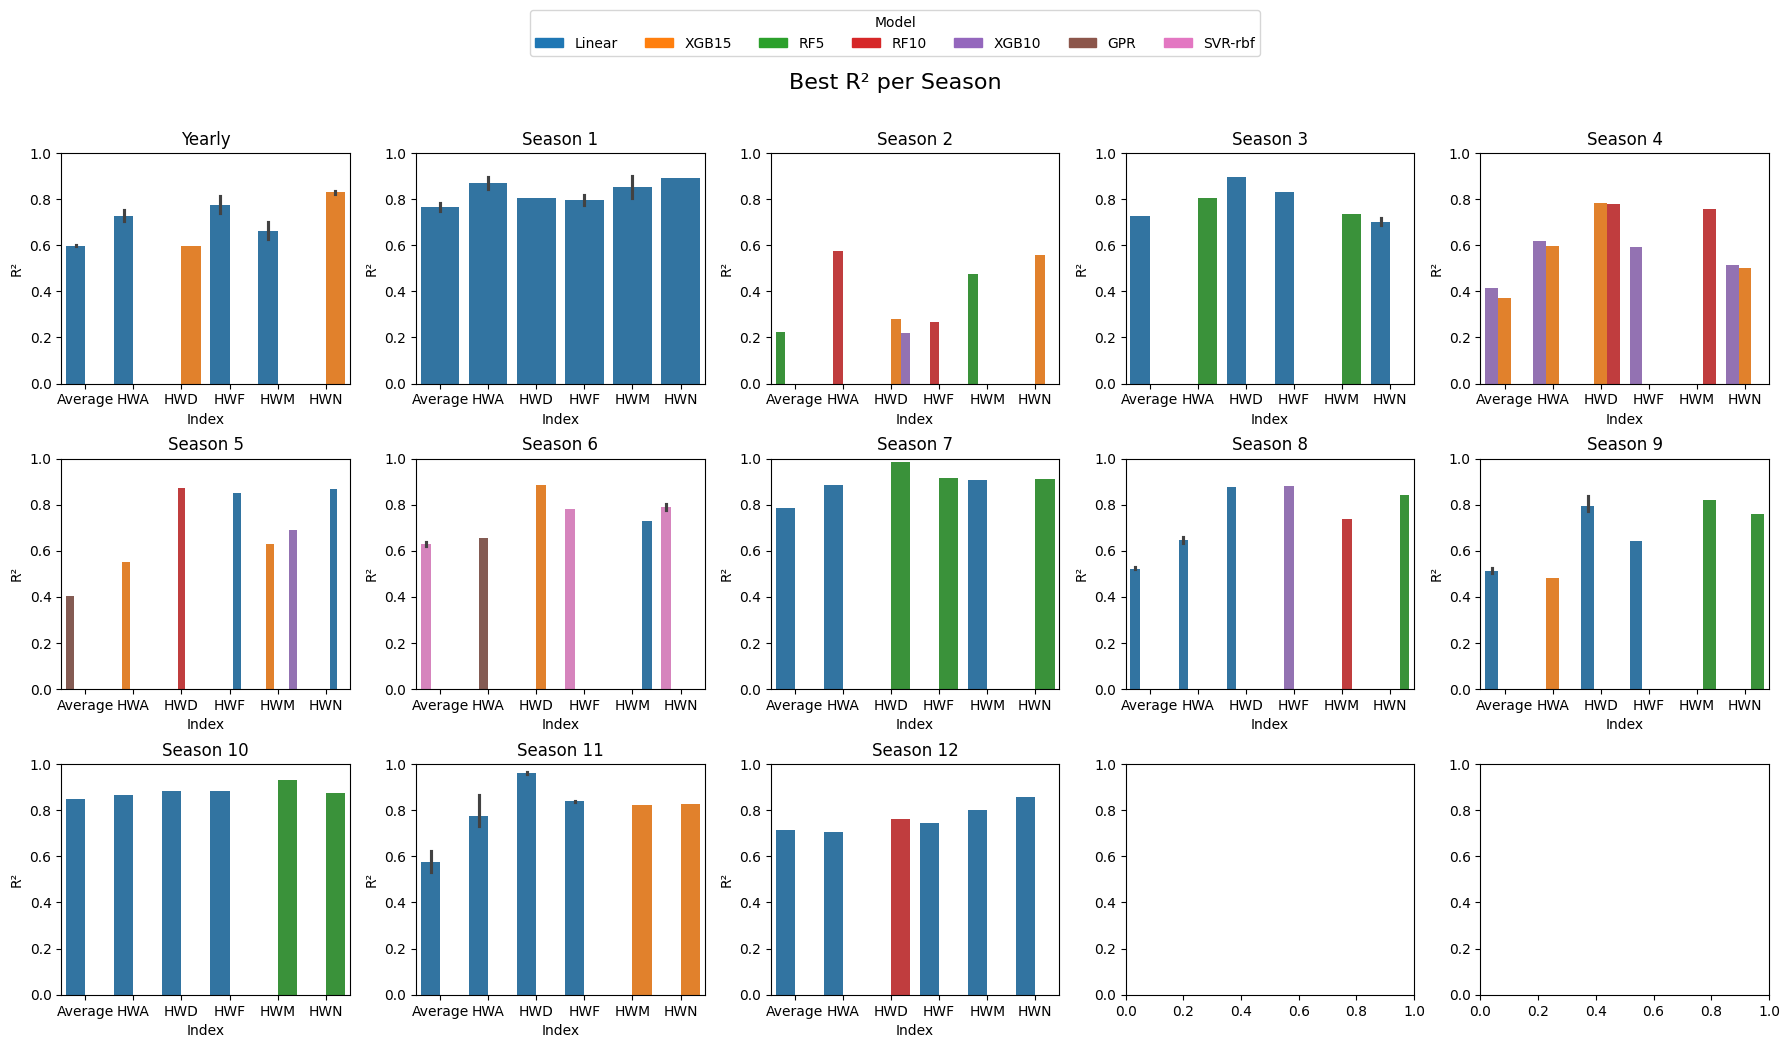

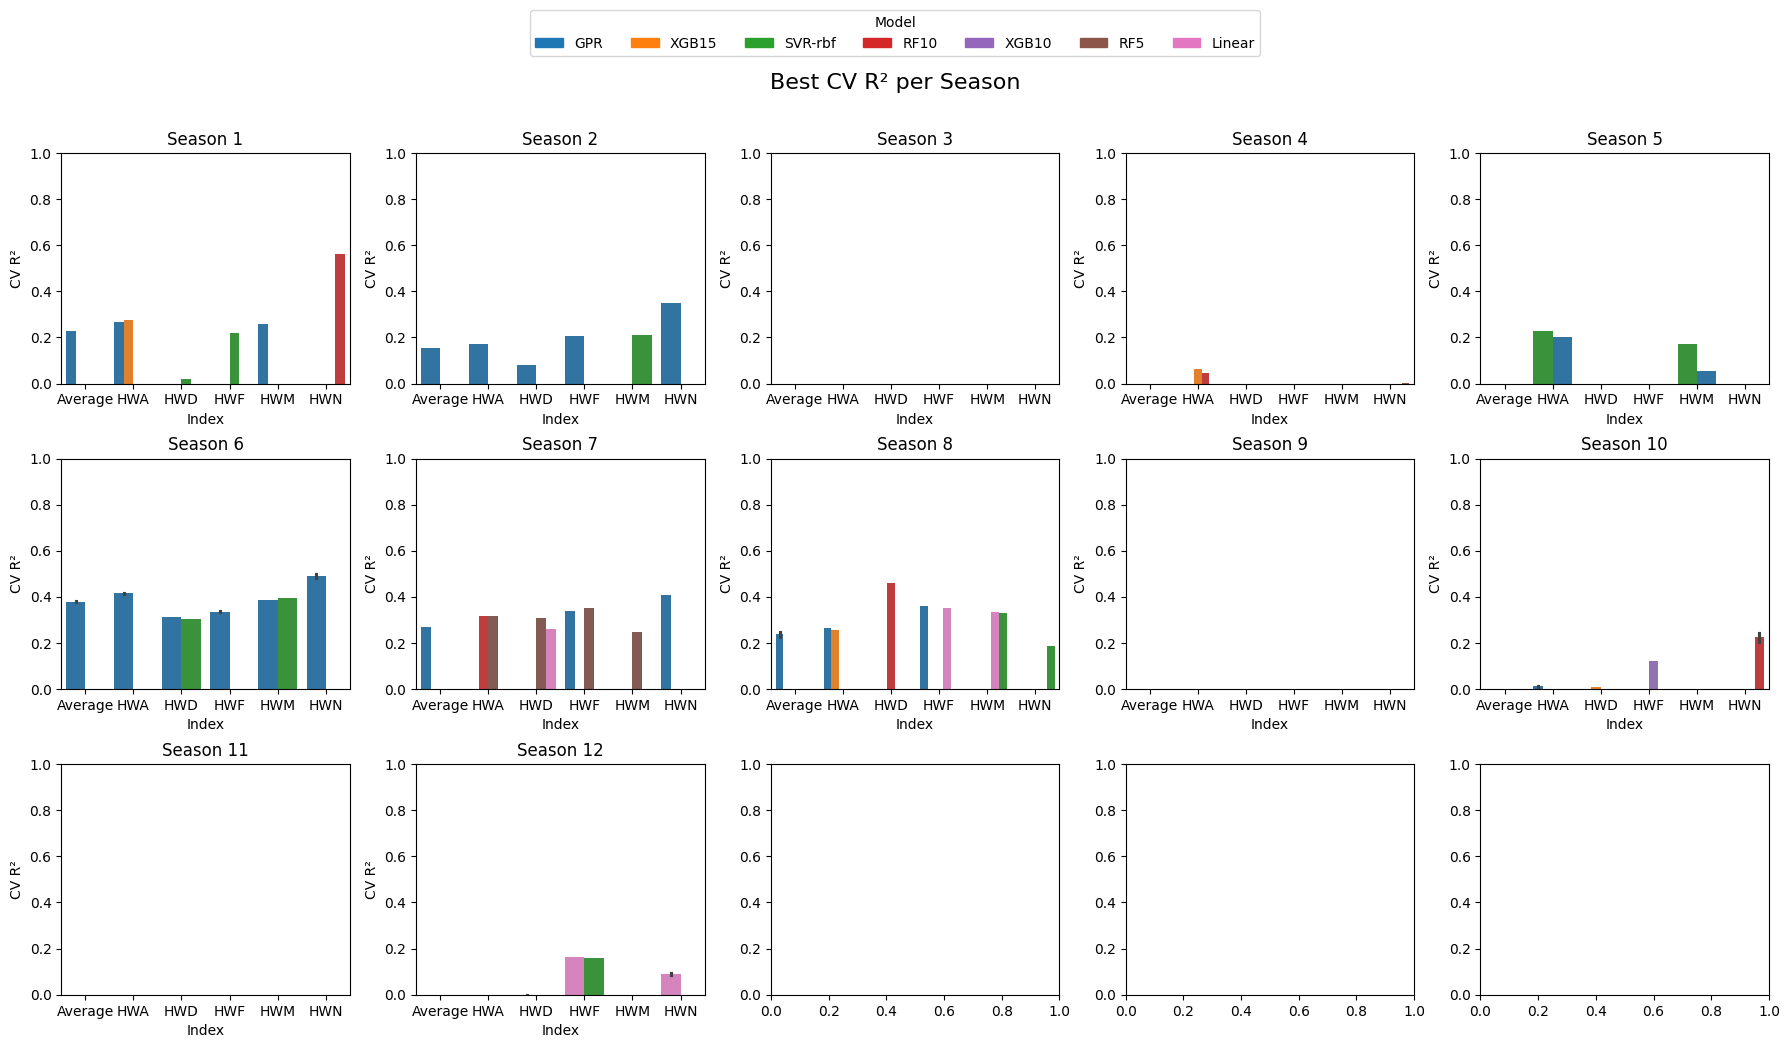

<Figure size 1800x1000 with 0 Axes>

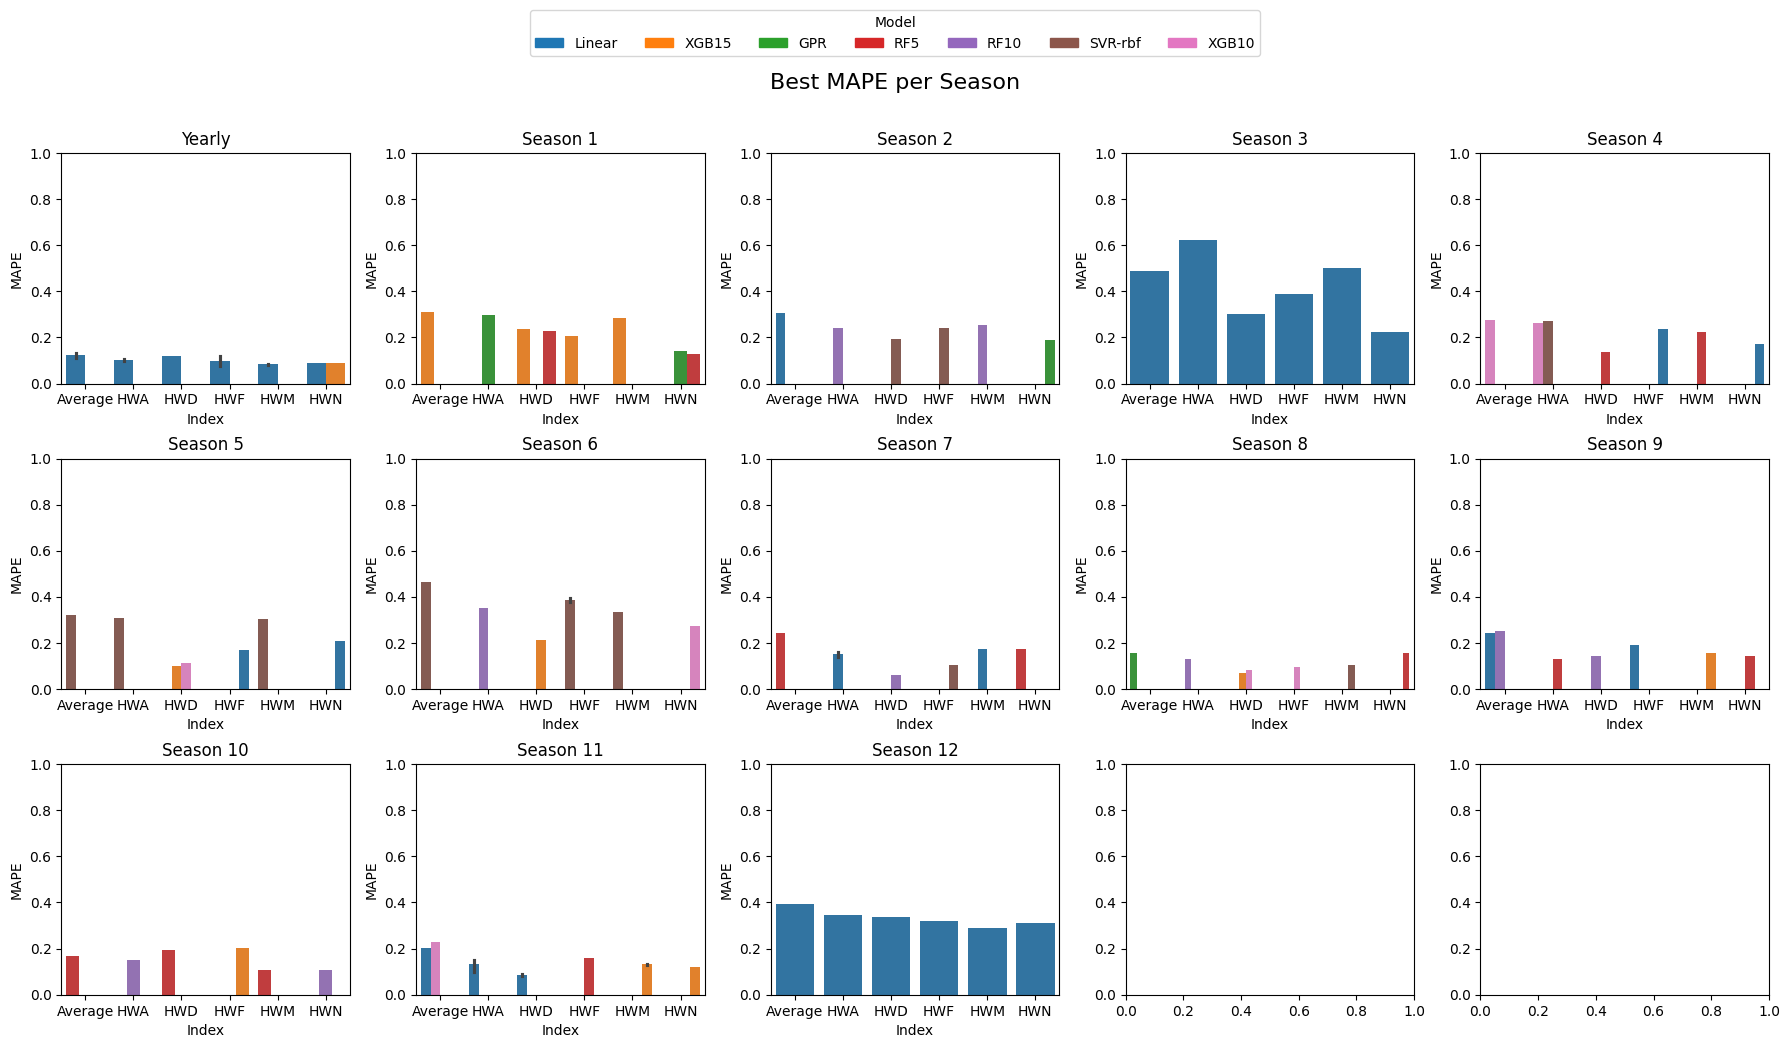

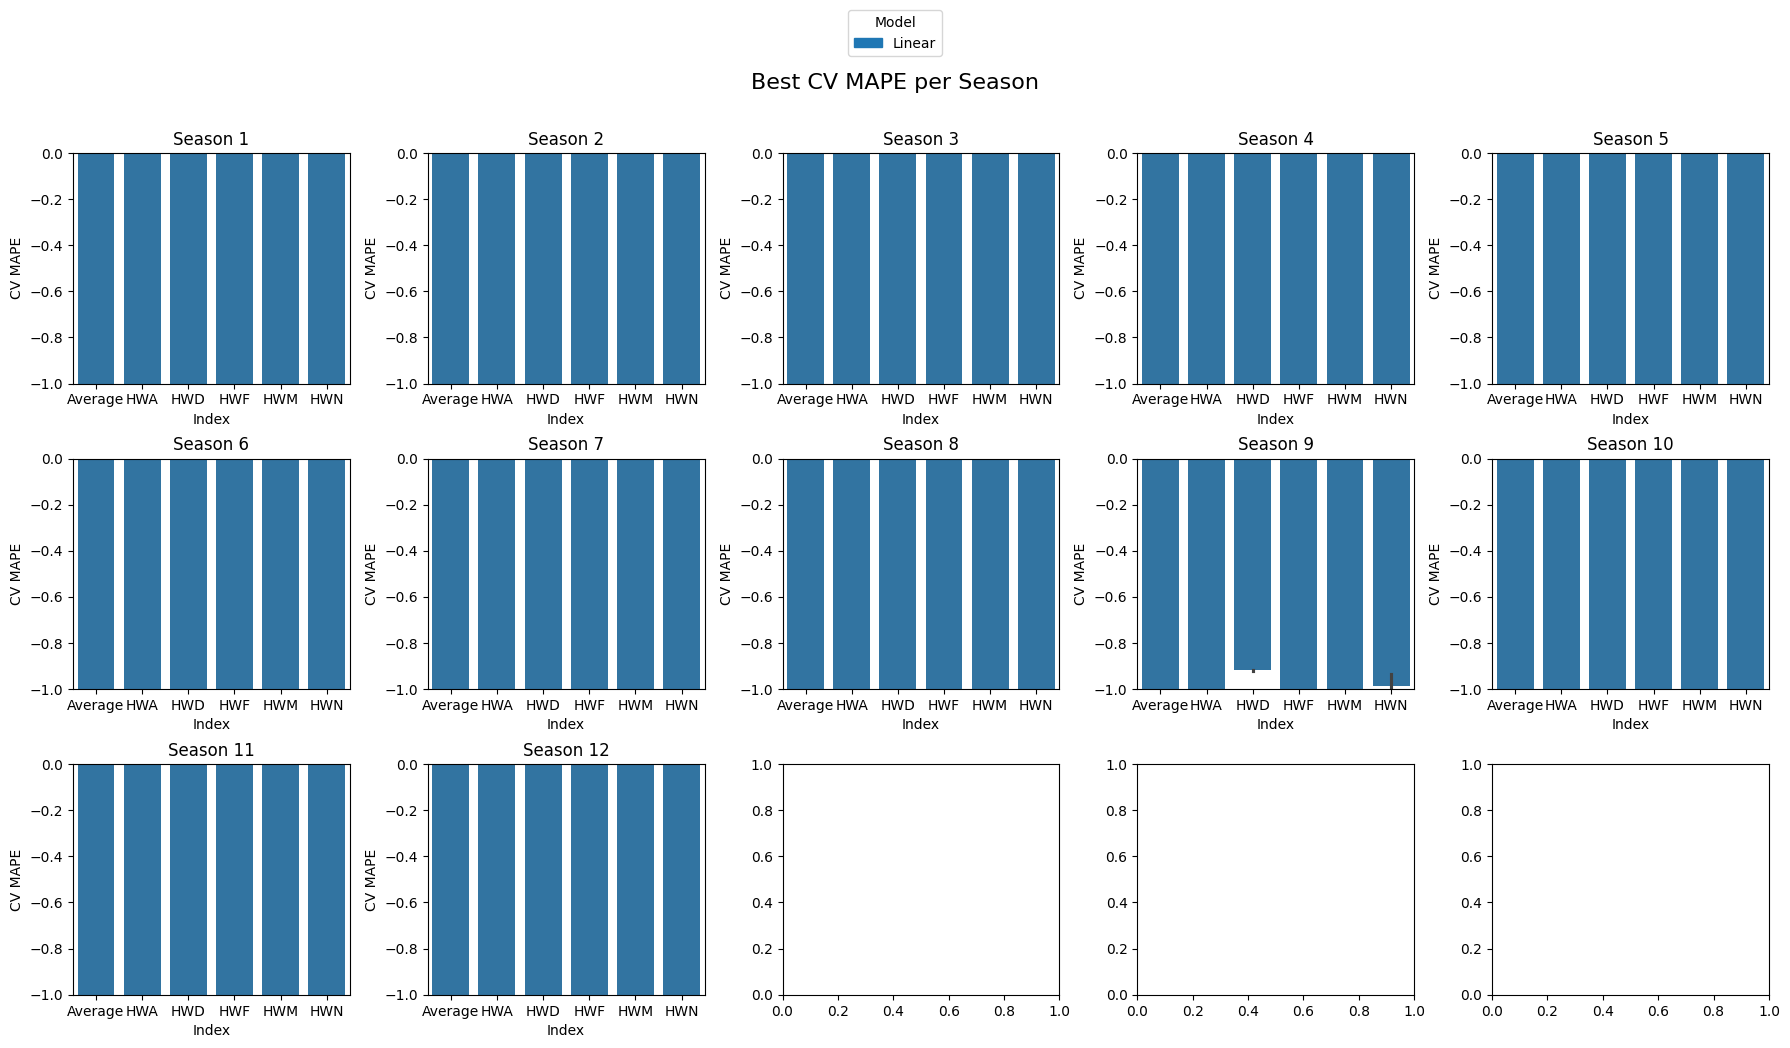

In [10]:
# Plot R2 results
plot_best_results_per_season(r2_seasons, "R²", "prediction", "Best R² per Season")

# Plot CV R2 results
plot_best_results_per_season(cv_r2_seasons, "CV R²", "CV","Best CV R² per Season")

# Plot MAPE results (invert y-axis since lower is better)
plt.figure(figsize=(18, 10))
plot_best_results_per_season(mape_seasons, "MAPE", "prediction", "Best MAPE per Season")
plot_best_results_per_season(cv_mape_seasons, "CV MAPE", "CV", "Best CV MAPE per Season")


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(cv_mape_seasons.sort_values("best_value", ascending=False))

,model,index,best_value,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,extra_indices,only_sea
5,Linear,HWD,-9.168223e-01,31df530c,predictor_31df530c_9.parquet,0,30,0.15,3,2monthly,9,ps,PDO-ONI-SAM,True
4,Linear,HWD,-9.201411e-01,8684951e,predictor_8684951e_9.parquet,0,30,0.10,3,2monthly,9,ps,NaN,True
11,Linear,HWN,-9.344524e-01,8792aadb,predictor_8792aadb_9.parquet,0,30,NaN,2,2monthly,9,ps,PDO-ONI-SAM,True
10,Linear,HWN,-1.039521e+00,31df530c,predictor_31df530c_9.parquet,0,30,0.15,3,2monthly,9,ps,PDO-ONI-SAM,True
1,Linear,Average,-1.040289e+00,8792aadb,predictor_8792aadb_9.parquet,0,30,NaN,2,2monthly,9,ps,PDO-ONI-SAM,True
7,Linear,HWF,-1.134109e+00,31df530c,predictor_31df530c_9.parquet,0,30,0.15,3,2monthly,9,ps,PDO-ONI-SAM,True
3,Linear,HWA,-1.171452e+00,8792aadb,predictor_8792aadb_9.parquet,0,30,NaN,2,2monthly,9,ps,PDO-ONI-SAM,True
6,Linear,HWF,-1.172508e+00,8476ed61,predictor_8476ed61_9.parquet,0,30,0.15,2,2monthly,9,ps,PDO-ONI-SAM,False
0,Linear,Average,-1.178352e+00,31df530c,predictor_31df530c_9.parquet,0,30,0.15,3,2monthly,9,ps,PDO-ONI-SAM,True
10,Linear,HWN,-1.308389e+00,3026e6d4,predictor_3026e6d4_10.parquet,0,30,NaN,3,2monthly,10,ps,PDO-ONI-SAM,True


C:\Users\marti\AppData\Local\Temp\ipykernel_29836\4243647625.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


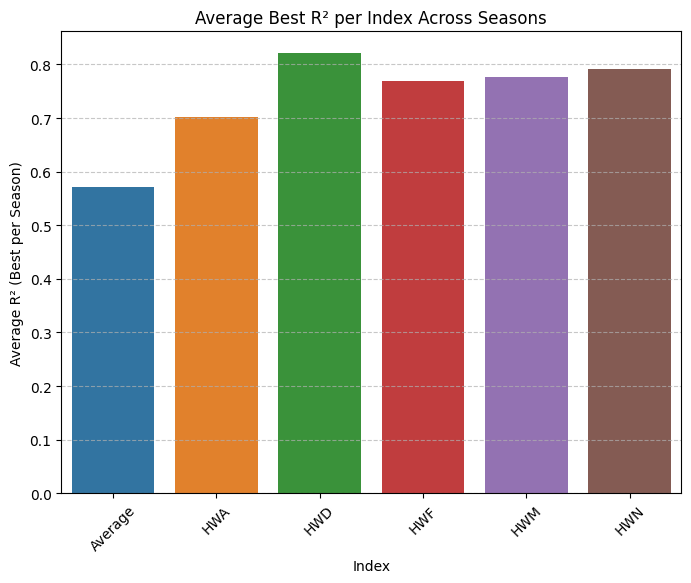

C:\Users\marti\AppData\Local\Temp\ipykernel_29836\4243647625.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


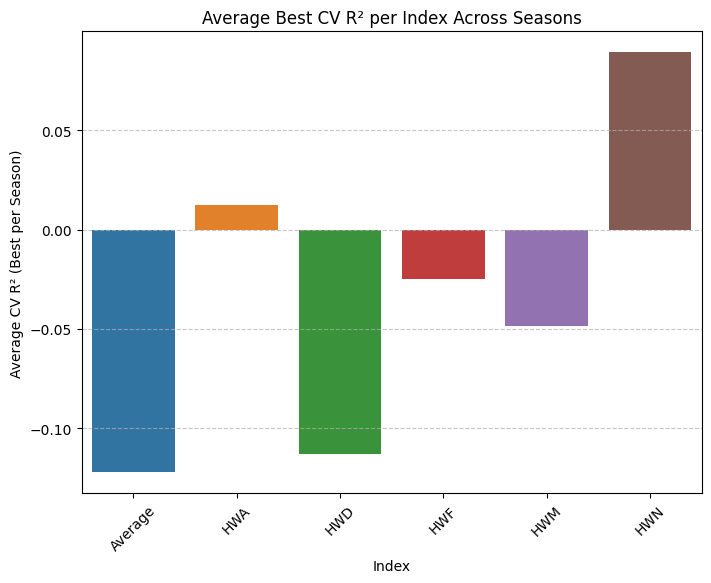

C:\Users\marti\AppData\Local\Temp\ipykernel_29836\4243647625.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


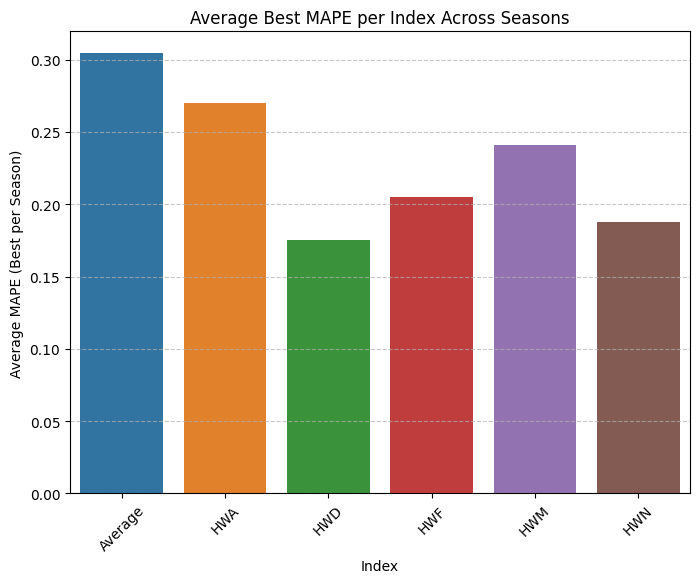

In [12]:
# Example usage
plot_average_best_results(r2_seasons, "R²", "Average Best R² per Index Across Seasons")
plot_average_best_results(cv_r2_seasons, "CV R²", "Average Best CV R² per Index Across Seasons")
plot_average_best_results(mape_seasons, "MAPE", "Average Best MAPE per Index Across Seasons")

In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(r2_seasons.sort_values("best_value", ascending=False))

,model,season,id_data,index,best_value,training_value,filename,boxes,top_n,var_thresh,modes,frequency,methods,extra_indices,only_sea
5,RF5,7,44440fcb,HWD,0.986058,0.811888,predictor_44440fcb_7.parquet,0,10,0.05,3,2monthly,ps,PDO-ONI-SAM,True
4,RF5,7,d53af68d,HWD,0.986058,0.811888,predictor_d53af68d_7.parquet,0,10,NaN,3,2monthly,ps,PDO-ONI-SAM,True
5,Linear,11,13978dd3,HWD,0.964174,0.617119,predictor_13978dd3_11.parquet,0,20,0.10,2,2monthly,ps,PDO-ONI-SAM,False
6,Linear,11,5cb46bcc,HWD,0.958226,0.618929,predictor_5cb46bcc_11.parquet,0,20,0.05,2,2monthly,ps,PDO-ONI-SAM,False
16,RF5,10,a1ecabc1,HWM,0.931446,0.822688,predictor_a1ecabc1_10.parquet,0,10,0.05,2,2monthly,ps,NaN,False
15,RF5,10,a23ee919,HWM,0.931446,0.822688,predictor_a23ee919_10.parquet,0,10,NaN,2,2monthly,ps,NaN,False
14,RF5,10,a23ee919,HWM,0.931446,0.822688,predictor_a23ee919_10.parquet,0,10,NaN,2,2monthly,ps,NaN,False
17,RF5,10,a1ecabc1,HWM,0.931446,0.822688,predictor_a1ecabc1_10.parquet,0,10,0.05,2,2monthly,ps,NaN,False
6,RF5,7,31df530c,HWF,0.917514,0.836105,predictor_31df530c_7.parquet,0,30,0.15,3,2monthly,ps,PDO-ONI-SAM,True
8,RF5,7,ce142c55,HWF,0.915469,0.858856,predictor_ce142c55_7.parquet,0,5,0.10,3,2monthly,ps,NaN,True


In [46]:
cv_r2_seasons[(cv_r2_seasons["best_value"] >= 0.4)]

,model,index,best_value,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,extra_indices,only_sea
10,RF10,HWN,0.559799,22250158,predictor_22250158_1.parquet,0,20,NaN,3,2monthly,1,ps,PDO-ONI-SAM,True
11,RF10,HWN,0.559799,14cc57d2,predictor_14cc57d2_1.parquet,0,20,0.05,3,2monthly,1,ps,PDO-ONI-SAM,True
2,GPR,HWA,0.417807,50062424,predictor_50062424_6.parquet,0,10,0.10,3,2monthly,6,ps,PDO-ONI-SAM,False
3,GPR,HWA,0.414319,a931928c,predictor_a931928c_6.parquet,0,30,0.10,2,2monthly,6,ps,PDO-ONI-SAM,False
10,GPR,HWN,0.499246,50062424,predictor_50062424_6.parquet,0,10,0.10,3,2monthly,6,ps,PDO-ONI-SAM,False
11,GPR,HWN,0.483840,55ab791c,predictor_55ab791c_6.parquet,0,10,NaN,3,2monthly,6,ps,PDO-ONI-SAM,False
10,GPR,HWN,0.406900,e6cc51a4,predictor_e6cc51a4_7.parquet,0,5,NaN,3,2monthly,7,ps,NaN,False
11,GPR,HWN,0.406900,38007502,predictor_38007502_7.parquet,0,5,0.05,3,2monthly,7,ps,NaN,False
4,RF10,HWD,0.458651,55ab791c,predictor_55ab791c_8.parquet,0,10,NaN,3,2monthly,8,ps,PDO-ONI-SAM,False
5,RF10,HWD,0.458651,3f23c98e,predictor_3f23c98e_8.parquet,0,10,0.05,3,2monthly,8,ps,PDO-ONI-SAM,False


In [ ]:
with open("pcas_1972.pkl", "rb") as inp:
    pcas_sst = pickle.load(inp)
interest_ids = cv_r2_seasons[(cv_r2_seasons["best_value"] >= 0.4)]
df1 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["only_sea"] == False:
        continue
    else:
        temp = ""
        data_file = pd.read_parquet(f"data/new_features{temp}/{region}/predictor_{id}_{season}.parquet")
        if "PDO" not in row["extra_indices"]:
            pcas = list(data_file.columns[5:])
        else:
            pcas = list(data_file.columns[5:-3])
            for index in list(data_file.columns[-3:]):
                df1.loc[k] = [id, None, None, None, index]
                k+=1
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_sst[id_pca].variables_dict.values())
            box = pcas_sst[id_pca].box
            mode = pcas[i][-1]
            df1.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_sst
display(df1)



,id_data,id_pca,mode,box,variables
0,22250158,None,None,None,PDO
1,22250158,None,None,None,ONI
2,22250158,None,None,None,SAM
3,22250158,131,3,"[205, 247.5, 30, 60]",[Z]
4,22250158,1085,3,"[205, 290, 30, 60]","[SP, Z]"
5,22250158,140,3,"[205, 247.5, 30, 60]","[SP, Z]"
6,22250158,1076,3,"[205, 290, 30, 60]",[Z]
7,22250158,161,3,"[205, 247.5, 30, 60]","[SP, U10, Z]"
8,22250158,1090,3,"[205, 290, 30, 60]","[U10, Z]"
9,22250158,127,3,"[205, 247.5, 30, 60]",[SP]


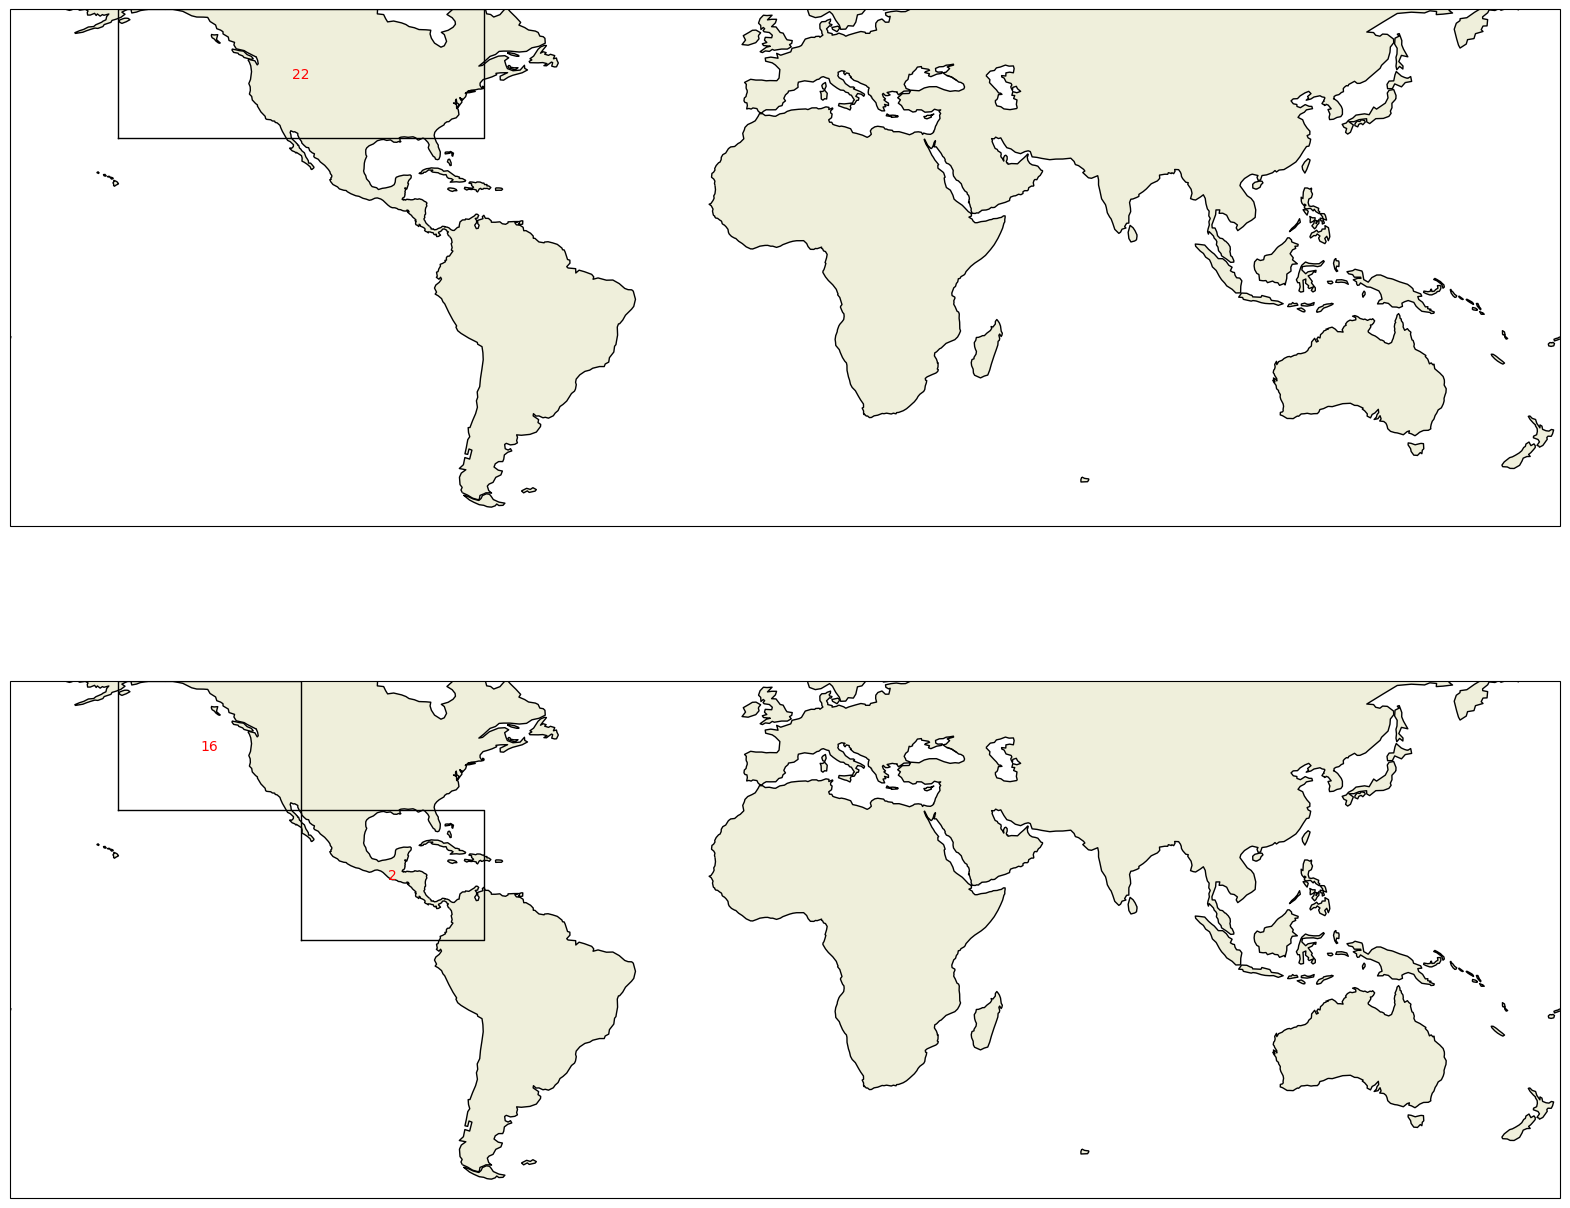

In [54]:
plot_grid_count(df1)

In [ ]:
with open("pcas_t2m.pkl", "rb") as inp:
    pcas_t2m = pickle.load(inp)
df2 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["only_sea"] == False:
        temp = "_t2m"
        data_file = pd.read_parquet(f"data/new_features{temp}/{region}/predictor_{id}_{season}.parquet")
        if "PDO" not in str(row["extra_indices"]):
            pcas = list(data_file.columns[5:])
        else:
            pcas = list(data_file.columns[5:-3])
            for index in list(data_file.columns[-3:]):
                df1.loc[k] = [id, None, None, None, index]
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_t2m[id_pca].variables_dict.values())
            box = pcas_t2m[id_pca].box
            mode = pcas[i][-1]
            df2.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_t2m
display(df2)

,id_data,id_pca,mode,box,variables
0,50062424,153,3,"[205, 247.5, 30, 60]","[SP, U10, T2M]"
1,50062424,136,3,"[205, 247.5, 30, 60]","[SP, T2M]"
2,50062424,152,3,"[205, 247.5, 30, 60]","[SP, U10, Z]"
3,50062424,135,3,"[205, 247.5, 30, 60]","[SP, Z]"
4,50062424,175,3,"[205, 247.5, 30, 60]","[SP, U10, Z, T2M]"
...,...,...,...,...,...
85,3f23c98e,181,3,"[205, 247.5, 30, 60]","[U10, V10, Z, T2M]"
86,3f23c98e,154,3,"[205, 247.5, 30, 60]","[SP, V10, Z]"
87,3f23c98e,176,3,"[205, 247.5, 30, 60]","[SP, V10, Z, T2M]"
88,3f23c98e,151,3,"[205, 247.5, 30, 60]","[SP, U10, V10]"


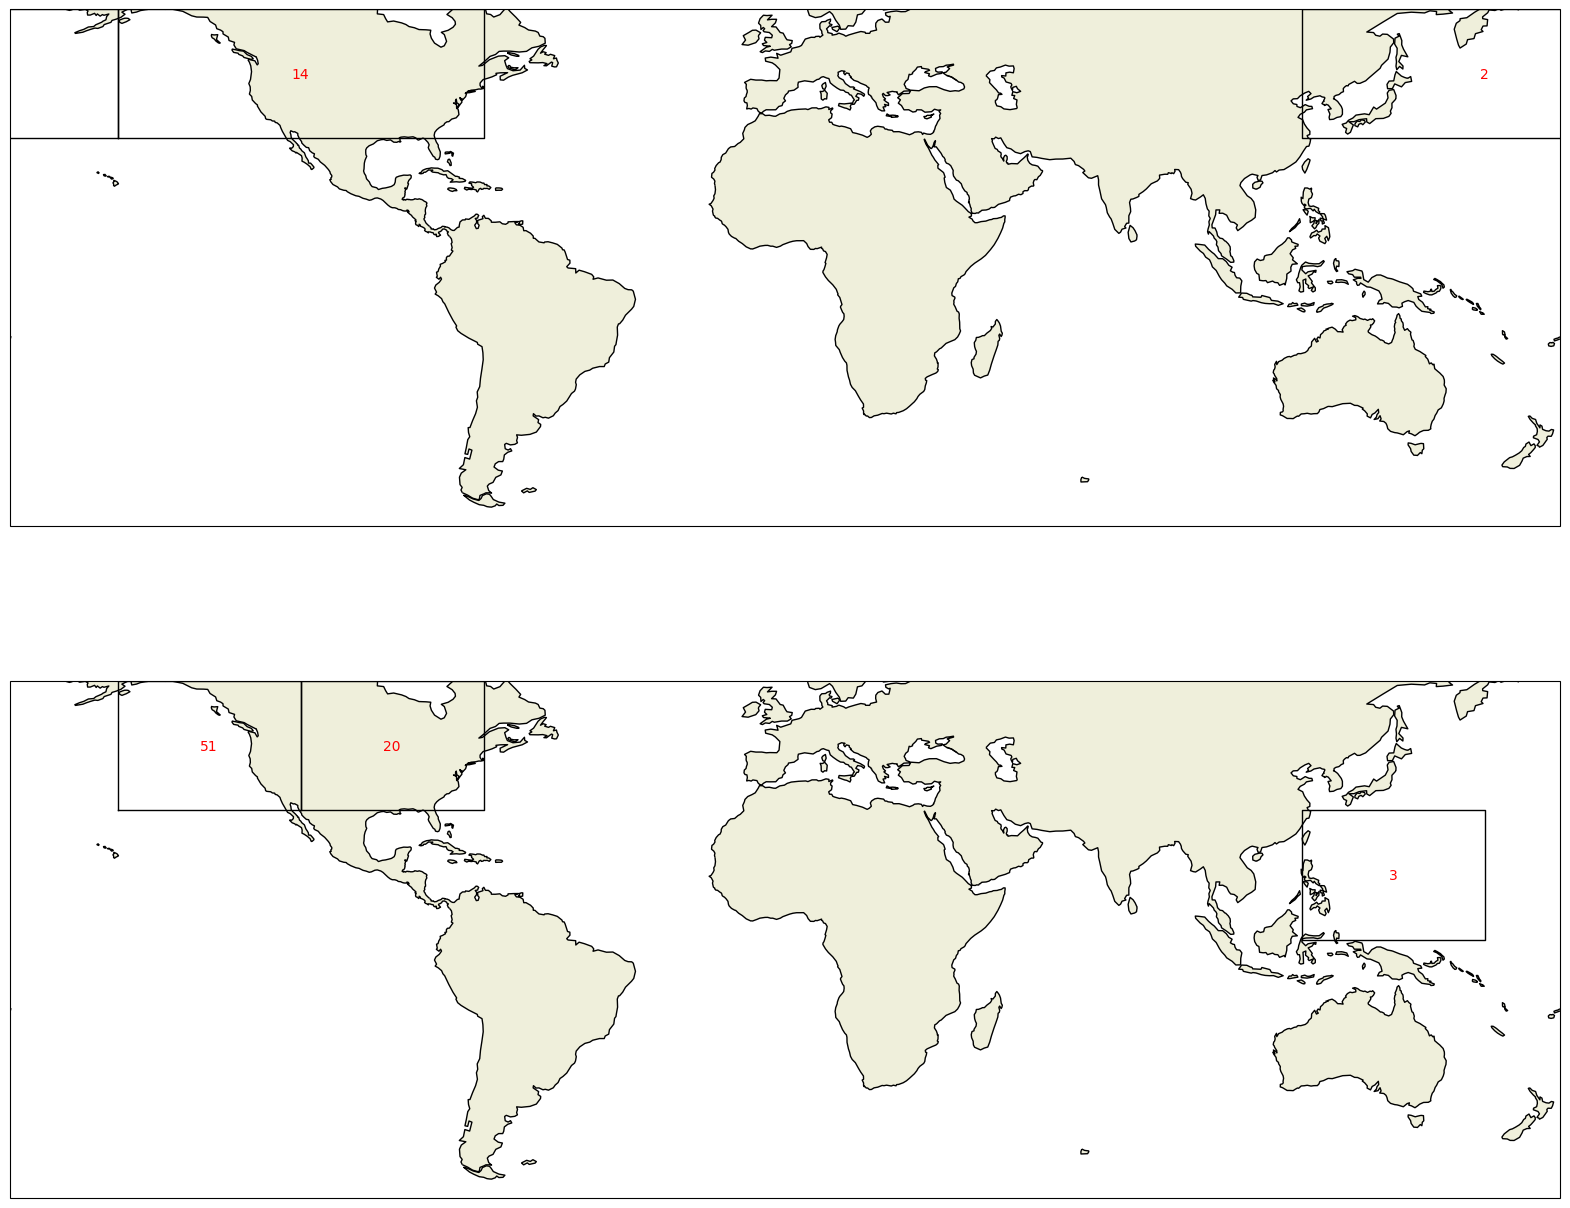

In [57]:
plot_grid_count(df2)

## Chile

In [58]:
region = "chile"
FREQUENCY= "2monthly"
metadata_sst = pd.read_csv(f"data/new_features/{region}/metadata.csv")
metadata_t2m = pd.read_csv(f"data/new_features_t2m/{region}/metadata.csv")
metadata = pd.concat((metadata_sst,metadata_t2m))
metadata.rename(columns={"id":"id_data"}, inplace=True)
metadata

,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,extra_indices,only_sea
0,193d753c,predictor_193d753c.parquet,0,5,NaN,1,yearly,0,ps,NaN,True
1,2775aa34,predictor_2775aa34.parquet,0,10,NaN,1,yearly,0,ps,NaN,True
2,25a8ed97,predictor_25a8ed97.parquet,0,15,NaN,1,yearly,0,ps,NaN,True
3,7da22af6,predictor_7da22af6.parquet,0,20,NaN,1,yearly,0,ps,NaN,True
4,daef6aaa,predictor_daef6aaa.parquet,0,30,NaN,1,yearly,0,ps,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
1495,a59026f4,predictor_a59026f4_8.parquet,0,30,0.15,3,2monthly,8,ps,PDO-ONI-SAM,False
1496,a59026f4,predictor_a59026f4_9.parquet,0,30,0.15,3,2monthly,9,ps,PDO-ONI-SAM,False
1497,a59026f4,predictor_a59026f4_10.parquet,0,30,0.15,3,2monthly,10,ps,PDO-ONI-SAM,False
1498,a59026f4,predictor_a59026f4_11.parquet,0,30,0.15,3,2monthly,11,ps,PDO-ONI-SAM,False


In [59]:
results_sst = pd.read_csv(f"data/{region}_results/results_sst.csv")
results_t2m = pd.read_csv(f"data/{region}_results/results.csv")
results = pd.concat((results_sst,results_t2m))
results

,model,season,metric,stage,HWN,HWF,HWD,HWM,HWA,Average,id_data
0,Linear,1,r2,prediction,-1.327297e-02,-4.946484e-01,-6.388608e-01,1.434809e-01,-7.387990e-03,-2.021379e-01,515c5f16
1,RF5,1,r2,prediction,-5.701550e-01,-1.468624e+00,-1.518753e+00,-2.312815e-01,-1.423819e-01,-7.862392e-01,515c5f16
2,RF10,1,r2,prediction,-6.750969e-01,-1.390106e+00,-1.573718e+00,-8.343378e-02,-6.806433e-01,-8.805995e-01,515c5f16
3,SVR-rbf,1,r2,prediction,-1.591073e-01,-1.274360e+00,-1.693932e+00,-2.362827e-01,-4.328865e-01,-7.593138e-01,515c5f16
4,XGB10,1,r2,prediction,-7.380513e-01,-1.100790e+00,-8.702282e-01,-4.305569e-01,-5.886396e-01,-7.456532e-01,515c5f16
...,...,...,...,...,...,...,...,...,...,...,...
115075,RF10,12,mape,CV,-1.369845e+14,-4.989988e+14,-4.407523e+14,-2.031217e+14,-3.661497e+14,-3.292014e+14,a59026f4
115076,SVR-rbf,12,mape,CV,-1.836064e+14,-5.728179e+14,-4.953445e+14,-2.262063e+14,-4.251916e+14,-3.806333e+14,a59026f4
115077,XGB10,12,mape,CV,-1.466697e+14,-5.654439e+14,-4.039723e+14,-2.183092e+14,-4.302005e+14,-3.529191e+14,a59026f4
115078,XGB15,12,mape,CV,-1.404239e+14,-5.564153e+14,-3.856115e+14,-2.108993e+14,-4.345773e+14,-3.455855e+14,a59026f4


In [60]:
# Example usage
summary_r2 = summarize_best_results_by_index(results, metadata, metric="r2", top_n=5, stage="prediction")
summary_mape = summarize_best_results_by_index(results, metadata, metric="mape", top_n=5, stage="prediction")
summary_cv_r2 = summarize_best_results_by_index(results, metadata, metric="r2", top_n=5, stage="CV")
summary_cv_mape = summarize_best_results_by_index(results, metadata, metric="mape", top_n=5, stage="CV")



In [61]:
summary_cv_r2

,model,season,id_data,index,best_value,filename,boxes,top_n,var_thresh,modes,frequency,methods,extra_indices,only_sea
0,RF10,7,8e8d7ea0,Average,0.109470,predictor_8e8d7ea0_7.parquet,0,20,NaN,3,2monthly,ps,NaN,False
1,RF10,7,f7fe5651,Average,0.109470,predictor_f7fe5651_7.parquet,0,20,0.05,3,2monthly,ps,NaN,False
2,RF10,7,a99a9a57,Average,0.102221,predictor_a99a9a57_7.parquet,0,30,0.10,3,2monthly,ps,NaN,False
3,GPR,7,c35f74dd,Average,0.097267,predictor_c35f74dd_7.parquet,0,30,NaN,3,2monthly,ps,NaN,False
4,GPR,7,86c0db7a,Average,0.097267,predictor_86c0db7a_7.parquet,0,30,0.05,3,2monthly,ps,NaN,False
5,SVR-rbf,8,c35f74dd,HWA,0.127256,predictor_c35f74dd_8.parquet,0,30,NaN,3,2monthly,ps,NaN,False
6,SVR-rbf,8,86c0db7a,HWA,0.127256,predictor_86c0db7a_8.parquet,0,30,0.05,3,2monthly,ps,NaN,False
7,SVR-rbf,8,a99a9a57,HWA,0.111701,predictor_a99a9a57_8.parquet,0,30,0.10,3,2monthly,ps,NaN,False
8,RF10,7,c9589884,HWA,0.108277,predictor_c9589884_7.parquet,0,20,NaN,2,2monthly,ps,NaN,False
9,RF10,7,63fb9a3a,HWA,0.108277,predictor_63fb9a3a_7.parquet,0,20,0.05,2,2monthly,ps,NaN,False


Now we repite for each season

In [62]:
cv_r2_seasons = {}
cv_mape_seasons = {}
r2_seasons = {}
mape_seasons = {}
for i in range(13):
    results_season = results[results["season"]==i]
    cv_r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="r2",stage="CV" , top_n=2)
    r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="r2",stage="prediction", top_n=2)
    mape_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="mape",stage="prediction", top_n=2)
    cv_mape_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="mape",stage="CV", top_n=2)

cv_r2_seasons = pd.concat(list(cv_r2_seasons.values()))
cv_mape_seasons = pd.concat(list(cv_mape_seasons.values()))
r2_seasons = pd.concat(list(r2_seasons.values()))
mape_seasons = pd.concat(list(mape_seasons.values()))
print()
r2_seasons[["model","season", "index", "best_value", "training_value", "top_n", "var_thresh", "extra_indices", "only_sea"]].to_csv("r2_per_season.csv", index=False)
cv_r2_seasons[["model","season", "index", "best_value", "top_n", "var_thresh","extra_indices", "only_sea"]].to_csv("r2_CV_per_season.csv", index=False)

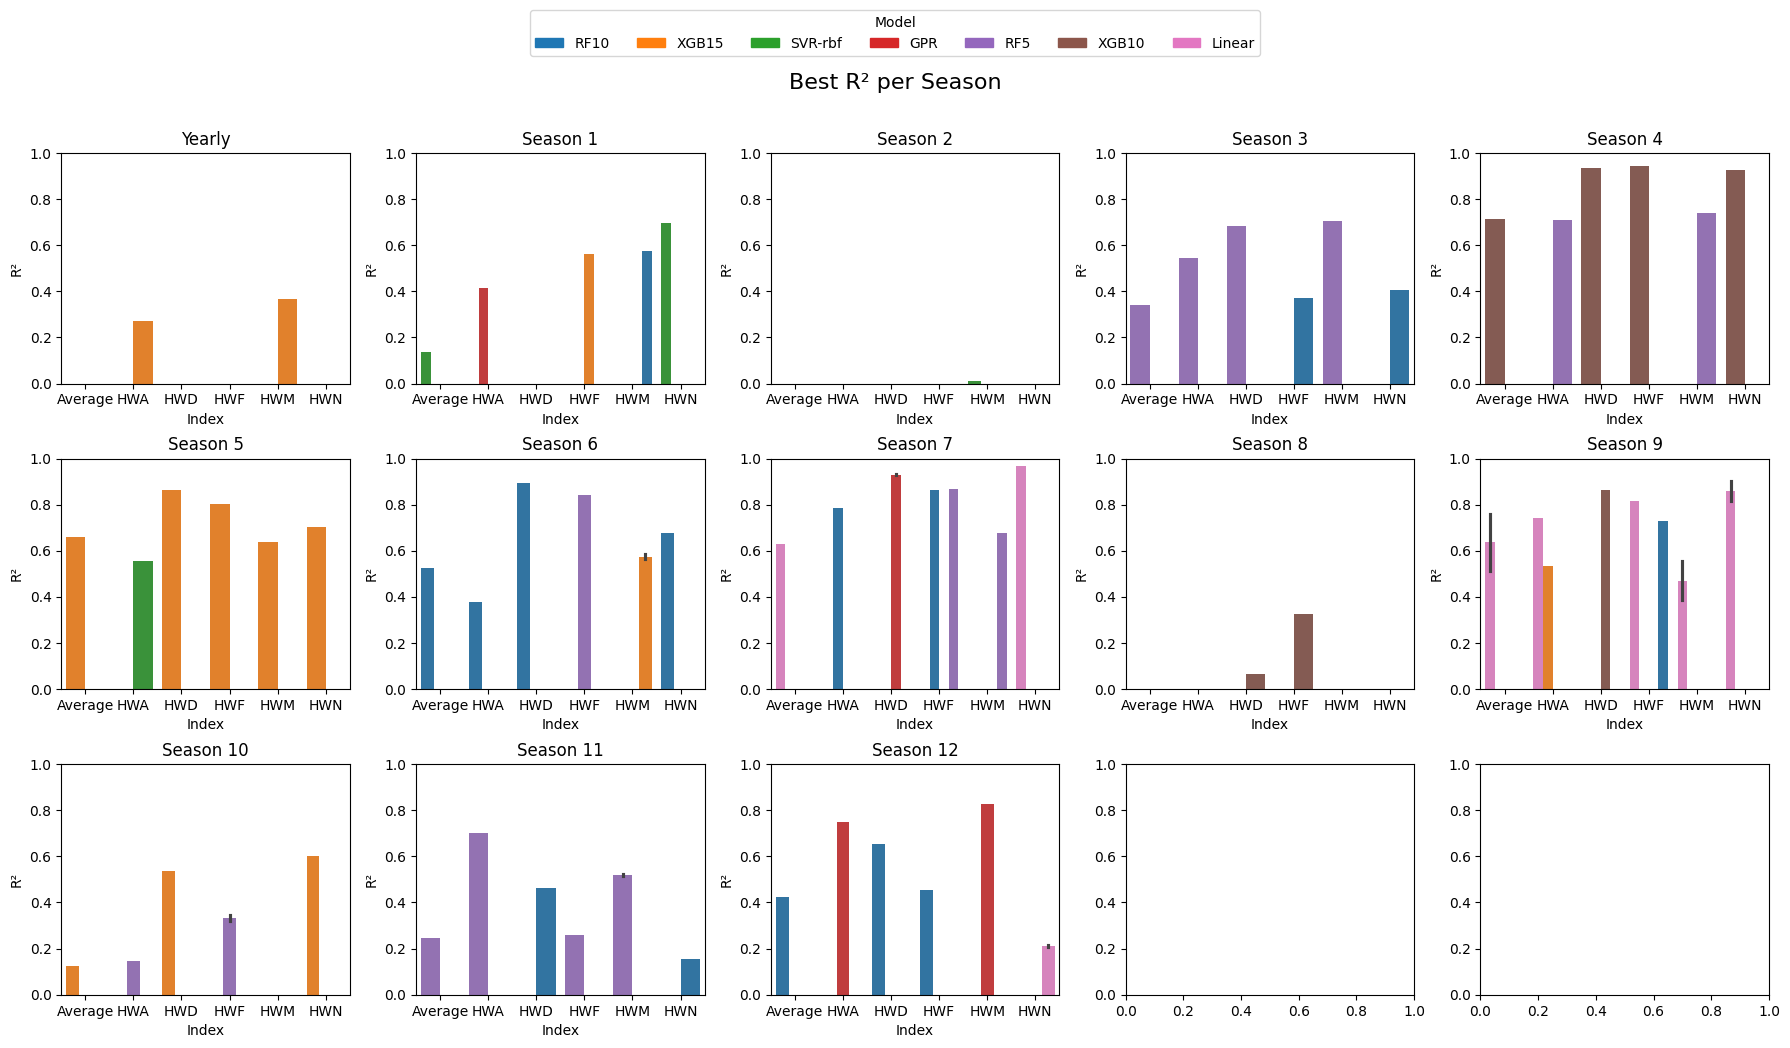

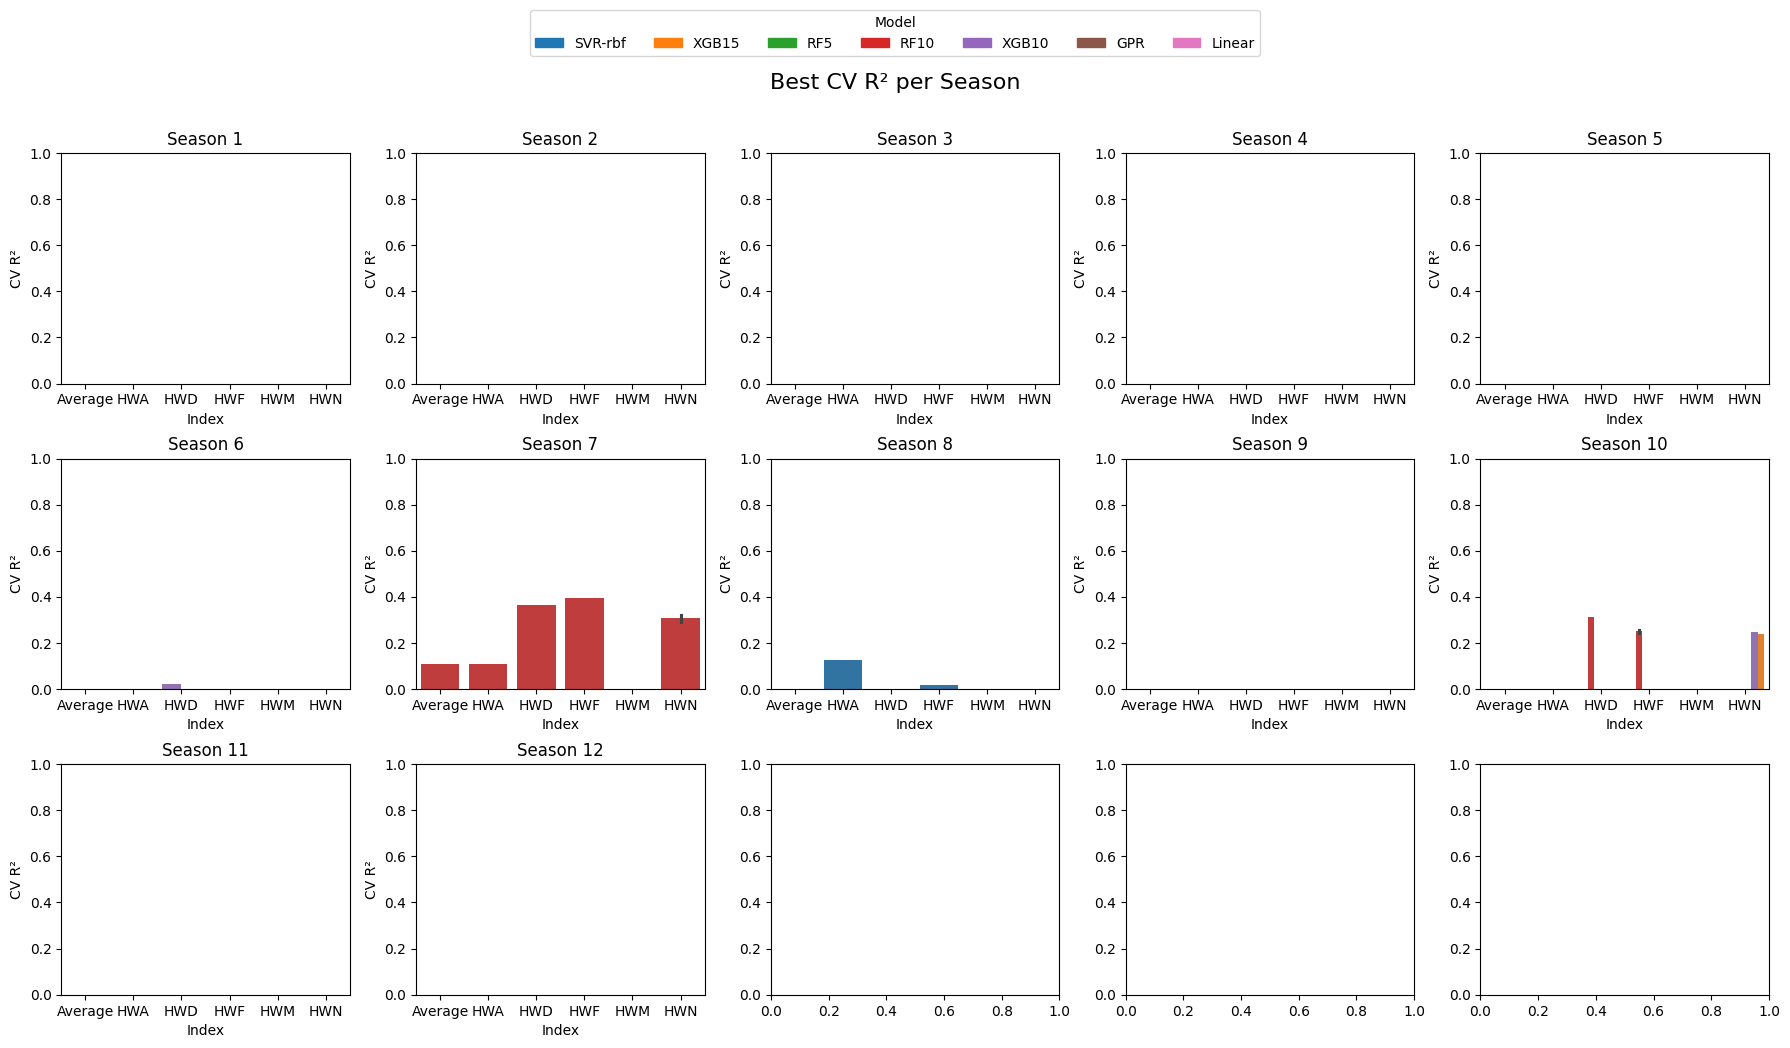

<Figure size 1800x1000 with 0 Axes>

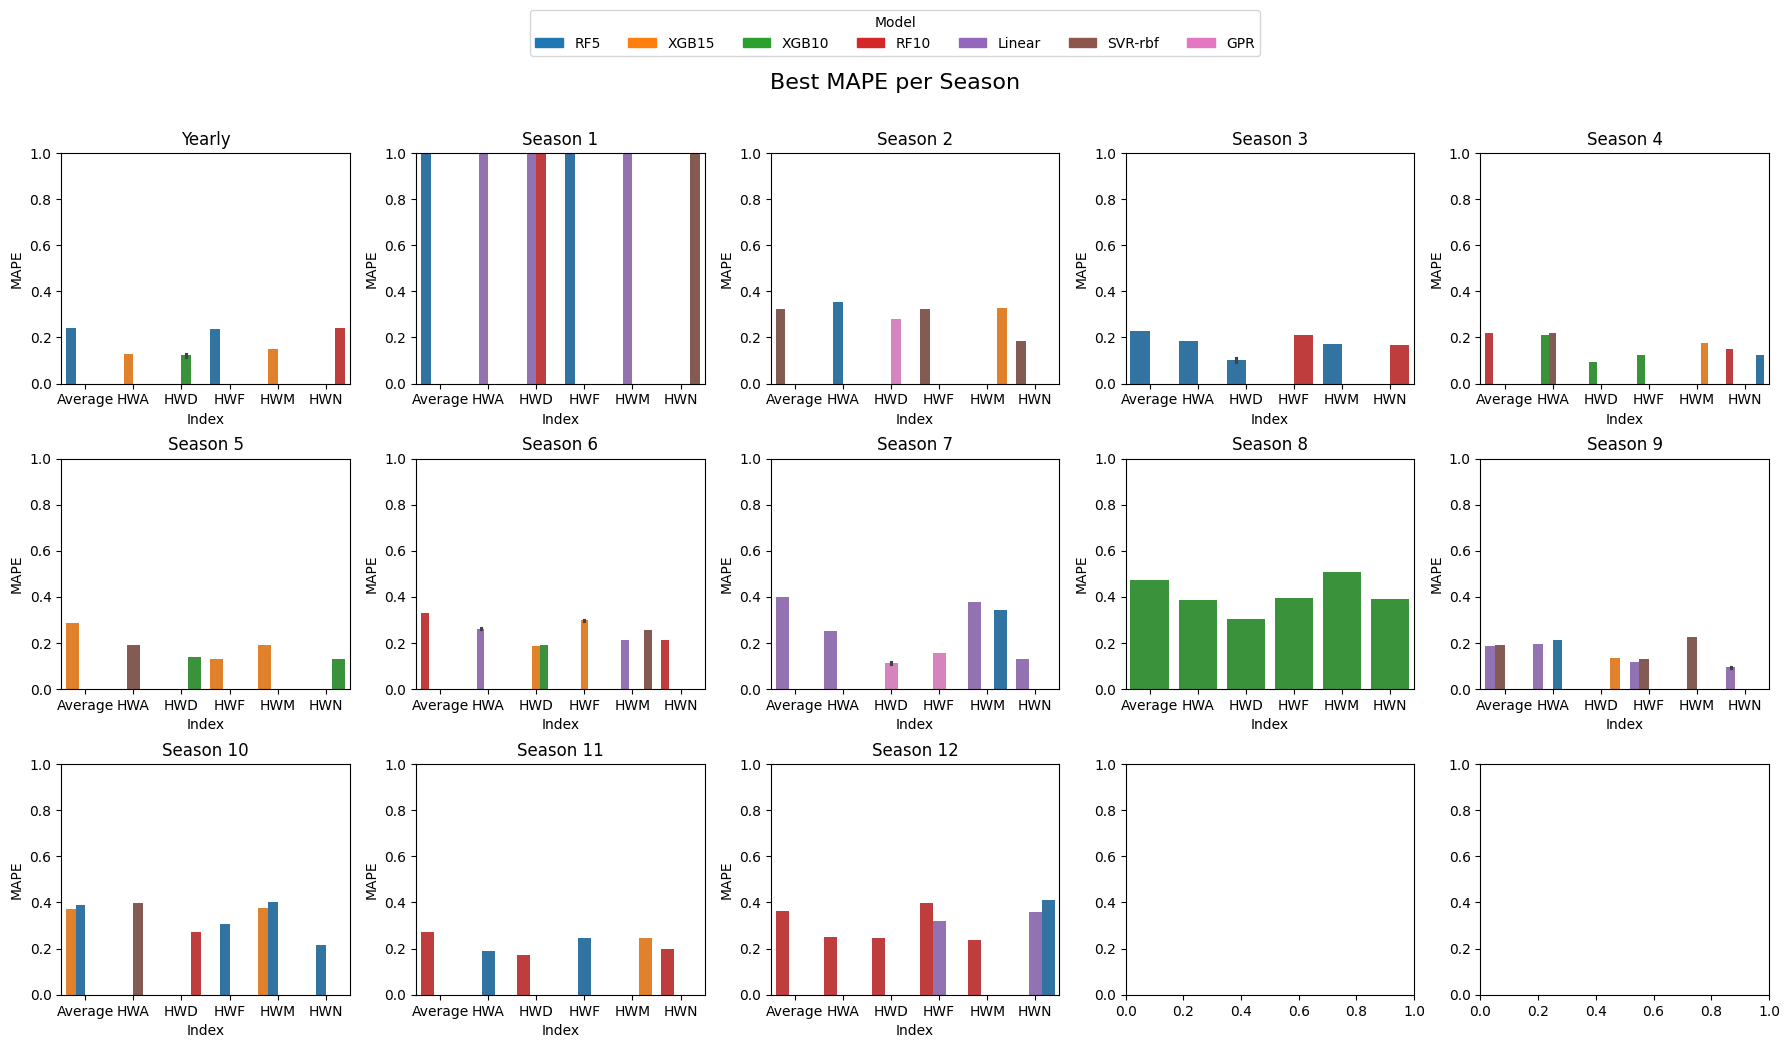

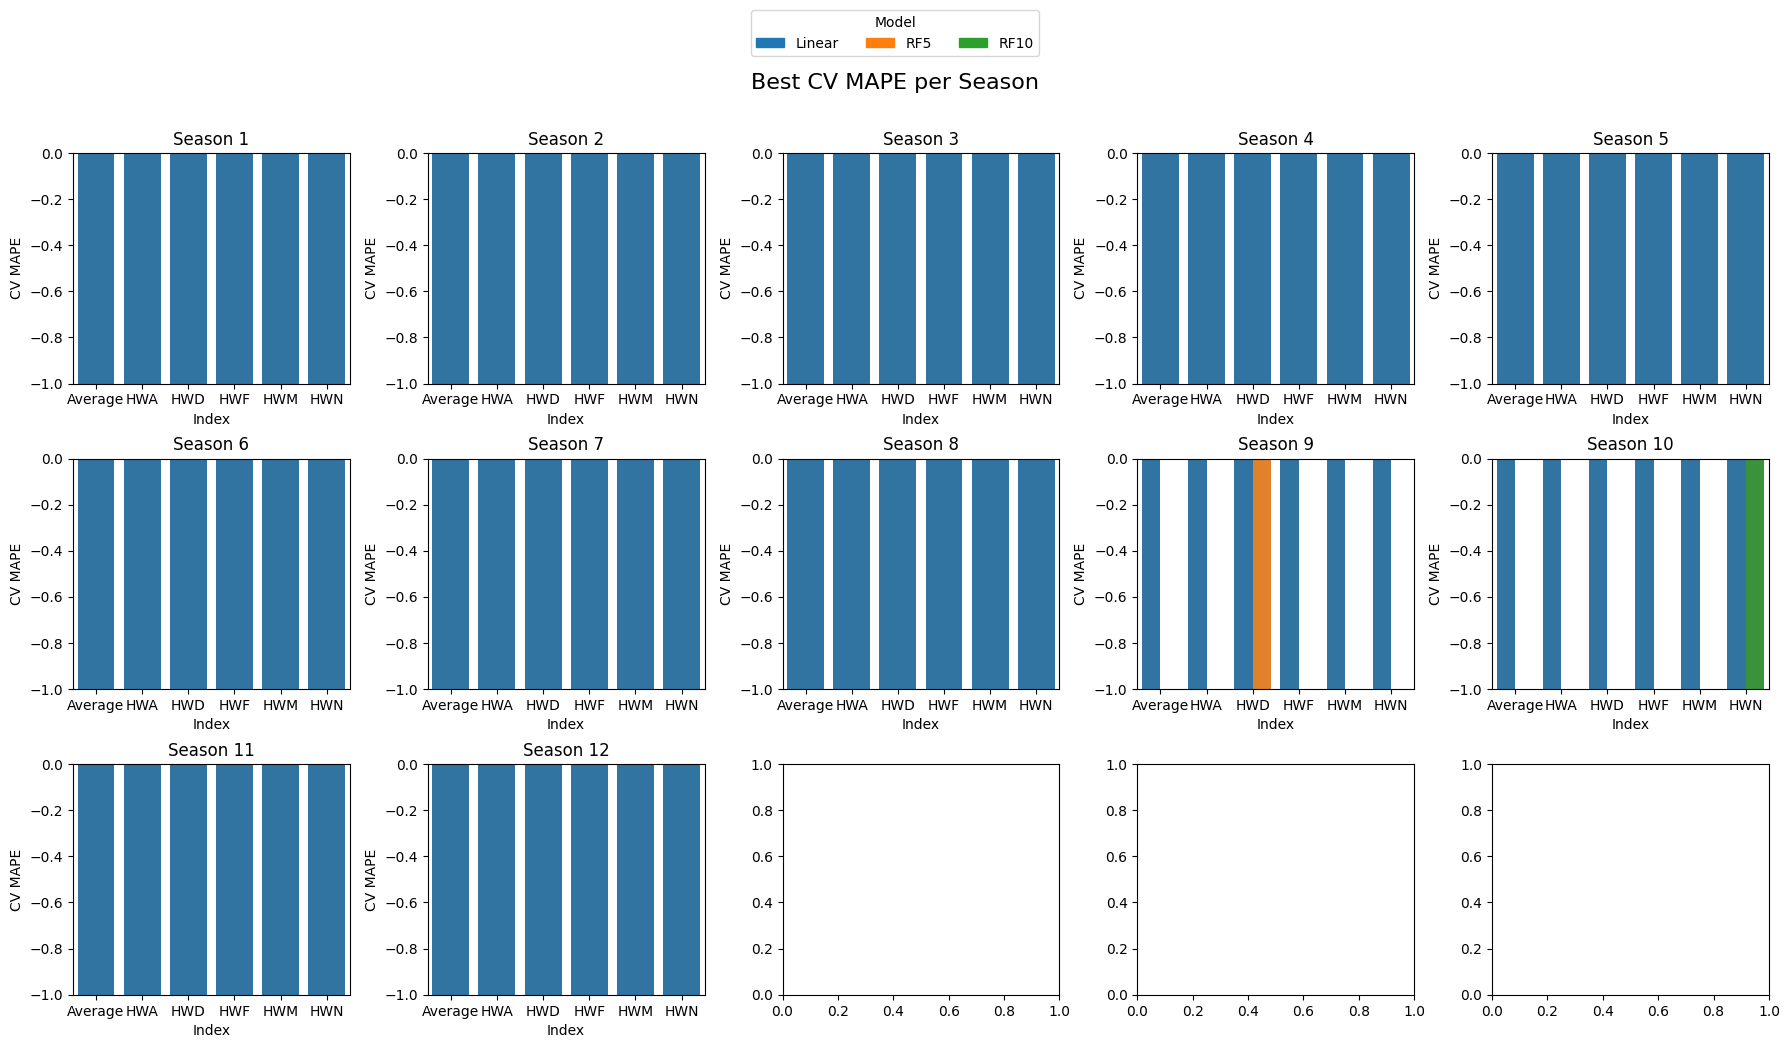

In [63]:
# Plot R2 results
plot_best_results_per_season(r2_seasons, "R²", "prediction", "Best R² per Season")

# Plot CV R2 results
plot_best_results_per_season(cv_r2_seasons, "CV R²", "CV","Best CV R² per Season")

# Plot MAPE results (invert y-axis since lower is better)
plt.figure(figsize=(18, 10))
plot_best_results_per_season(mape_seasons, "MAPE", "prediction", "Best MAPE per Season")
plot_best_results_per_season(cv_mape_seasons, "CV MAPE", "CV", "Best CV MAPE per Season")


In [64]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(cv_mape_seasons.sort_values("best_value", ascending=False))

,model,index,best_value,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,extra_indices,only_sea
11,Linear,HWN,-8.147593e+13,b8ee000f,predictor_b8ee000f_9.parquet,0,30,0.05,3,2monthly,9,ps,NaN,True
10,Linear,HWN,-8.476556e+13,90afcd47,predictor_90afcd47_9.parquet,0,30,0.05,3,2monthly,9,ps,PDO-ONI-SAM,True
11,Linear,HWN,-1.229180e+14,04a103c0,predictor_04a103c0_10.parquet,0,30,NaN,2,2monthly,10,ps,PDO-ONI-SAM,False
10,RF10,HWN,-1.261008e+14,ff60a104,predictor_ff60a104_10.parquet,0,30,0.15,3,2monthly,10,ps,NaN,False
11,Linear,HWN,-1.519711e+14,687e81e5,predictor_687e81e5_5.parquet,0,30,NaN,1,2monthly,5,ps,PDO-ONI-SAM,True
9,Linear,HWM,-1.519937e+14,b8ee000f,predictor_b8ee000f_9.parquet,0,30,0.05,3,2monthly,9,ps,NaN,True
8,Linear,HWM,-1.618749e+14,90afcd47,predictor_90afcd47_9.parquet,0,30,0.05,3,2monthly,9,ps,PDO-ONI-SAM,True
10,Linear,HWN,-1.731648e+14,b28cc104,predictor_b28cc104_5.parquet,0,30,NaN,3,2monthly,5,ps,PDO-ONI-SAM,True
10,Linear,HWN,-1.859428e+14,b3a4fa51,predictor_b3a4fa51_3.parquet,0,30,NaN,1,2monthly,3,ps,PDO-ONI-SAM,False
11,Linear,HWN,-1.859428e+14,758ae625,predictor_758ae625_3.parquet,0,30,0.05,1,2monthly,3,ps,PDO-ONI-SAM,False


C:\Users\marti\AppData\Local\Temp\ipykernel_1488\4243647625.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


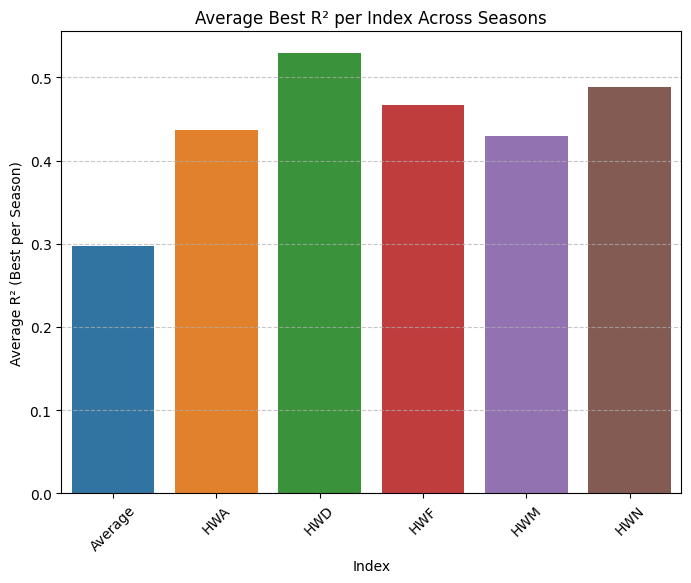

C:\Users\marti\AppData\Local\Temp\ipykernel_1488\4243647625.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


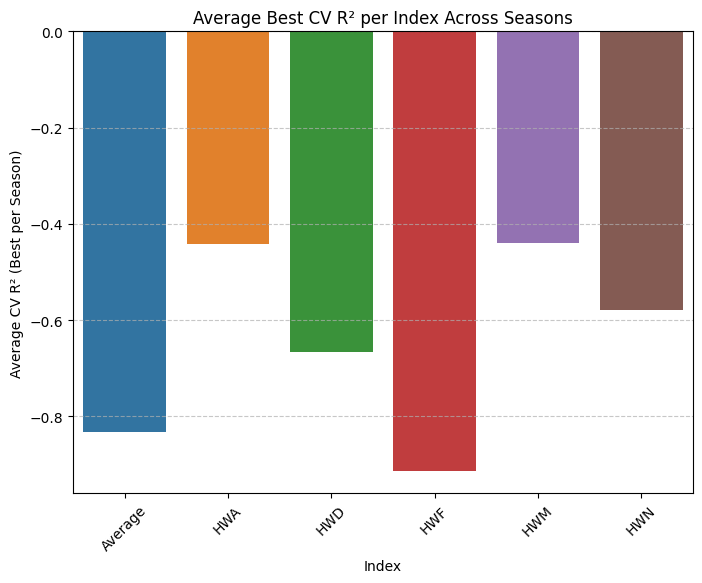

C:\Users\marti\AppData\Local\Temp\ipykernel_1488\4243647625.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


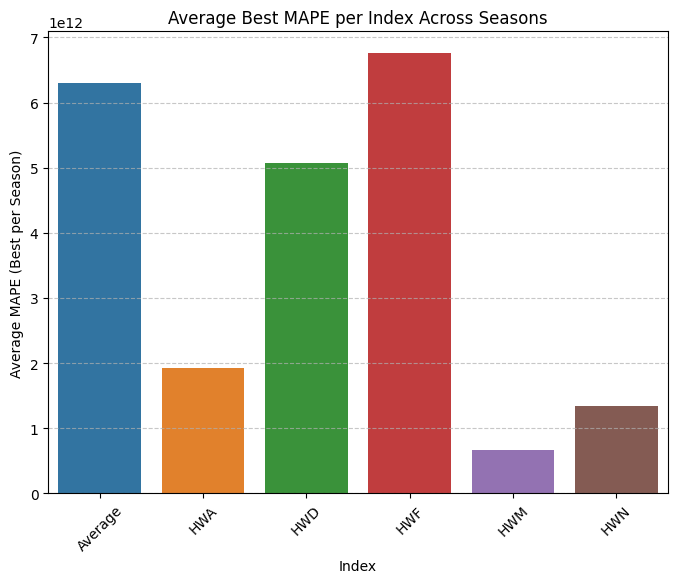

In [65]:
# Example usage
plot_average_best_results(r2_seasons, "R²", "Average Best R² per Index Across Seasons")
plot_average_best_results(cv_r2_seasons, "CV R²", "Average Best CV R² per Index Across Seasons")
plot_average_best_results(mape_seasons, "MAPE", "Average Best MAPE per Index Across Seasons")

In [66]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(cv_r2_seasons.sort_values("best_value", ascending=False))

,model,index,best_value,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,extra_indices,only_sea
7,RF10,HWF,0.396012,f7fe5651,predictor_f7fe5651_7.parquet,0,20,0.05,3,2monthly,7,ps,NaN,False
6,RF10,HWF,0.396012,8e8d7ea0,predictor_8e8d7ea0_7.parquet,0,20,NaN,3,2monthly,7,ps,NaN,False
5,RF10,HWD,0.365992,82de8d97,predictor_82de8d97_7.parquet,0,20,0.05,3,2monthly,7,ps,PDO-ONI-SAM,False
4,RF10,HWD,0.365992,9274c47c,predictor_9274c47c_7.parquet,0,20,NaN,3,2monthly,7,ps,PDO-ONI-SAM,False
10,RF10,HWN,0.323235,297f6641,predictor_297f6641_7.parquet,0,20,0.10,3,2monthly,7,ps,NaN,False
4,RF10,HWD,0.312780,915ed15f,predictor_915ed15f_10.parquet,0,20,NaN,3,2monthly,10,ps,PDO-ONI-SAM,True
5,RF10,HWD,0.312780,54b84553,predictor_54b84553_10.parquet,0,20,0.05,3,2monthly,10,ps,PDO-ONI-SAM,True
11,RF10,HWN,0.291144,e6816333,predictor_e6816333_7.parquet,0,15,0.10,3,2monthly,7,ps,NaN,False
6,RF10,HWF,0.256738,76aa8c6f,predictor_76aa8c6f_10.parquet,0,20,0.10,3,2monthly,10,ps,PDO-ONI-SAM,False
10,XGB10,HWN,0.249089,297f6641,predictor_297f6641_10.parquet,0,20,0.10,3,2monthly,10,ps,NaN,False


In [69]:
with open("pcas_1972.pkl", "rb") as inp:
    pcas_sst = pickle.load(inp)
interest_ids = cv_r2_seasons[(cv_r2_seasons["best_value"] >= 0.3)]
df1 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["only_sea"] == False:
        continue
    else:
        temp = ""
        data_file = pd.read_parquet(f"data/new_features{temp}/{region}/predictor_{id}_{season}.parquet")
        if "PDO" not in row["extra_indices"]:
            pcas = list(data_file.columns[5:])
        else:
            pcas = list(data_file.columns[5:-3])
            for index in list(data_file.columns[-3:]):
                df1.loc[k] = [id, None, None, None, index]
                k+=1
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_sst[id_pca].variables_dict.values())
            box = pcas_sst[id_pca].box
            mode = pcas[i][-1]
            df1.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_sst
display(df1)



,id_data,id_pca,mode,box,variables
0,915ed15f,None,None,None,PDO
1,915ed15f,None,None,None,ONI
2,915ed15f,None,None,None,SAM
3,915ed15f,950,3,"[247.5, 290, -60, -30]",[Z]
4,915ed15f,959,3,"[247.5, 290, -60, -30]","[SP, Z]"
5,915ed15f,980,3,"[247.5, 290, -60, -30]","[SP, U10, Z]"
6,915ed15f,650,3,"[205, 247.5, -30, 0]","[V10, Z]"
7,915ed15f,964,3,"[247.5, 290, -60, -30]","[U10, Z]"
8,915ed15f,946,3,"[247.5, 290, -60, -30]",[SP]
9,915ed15f,635,3,"[205, 247.5, -30, 0]",[Z]


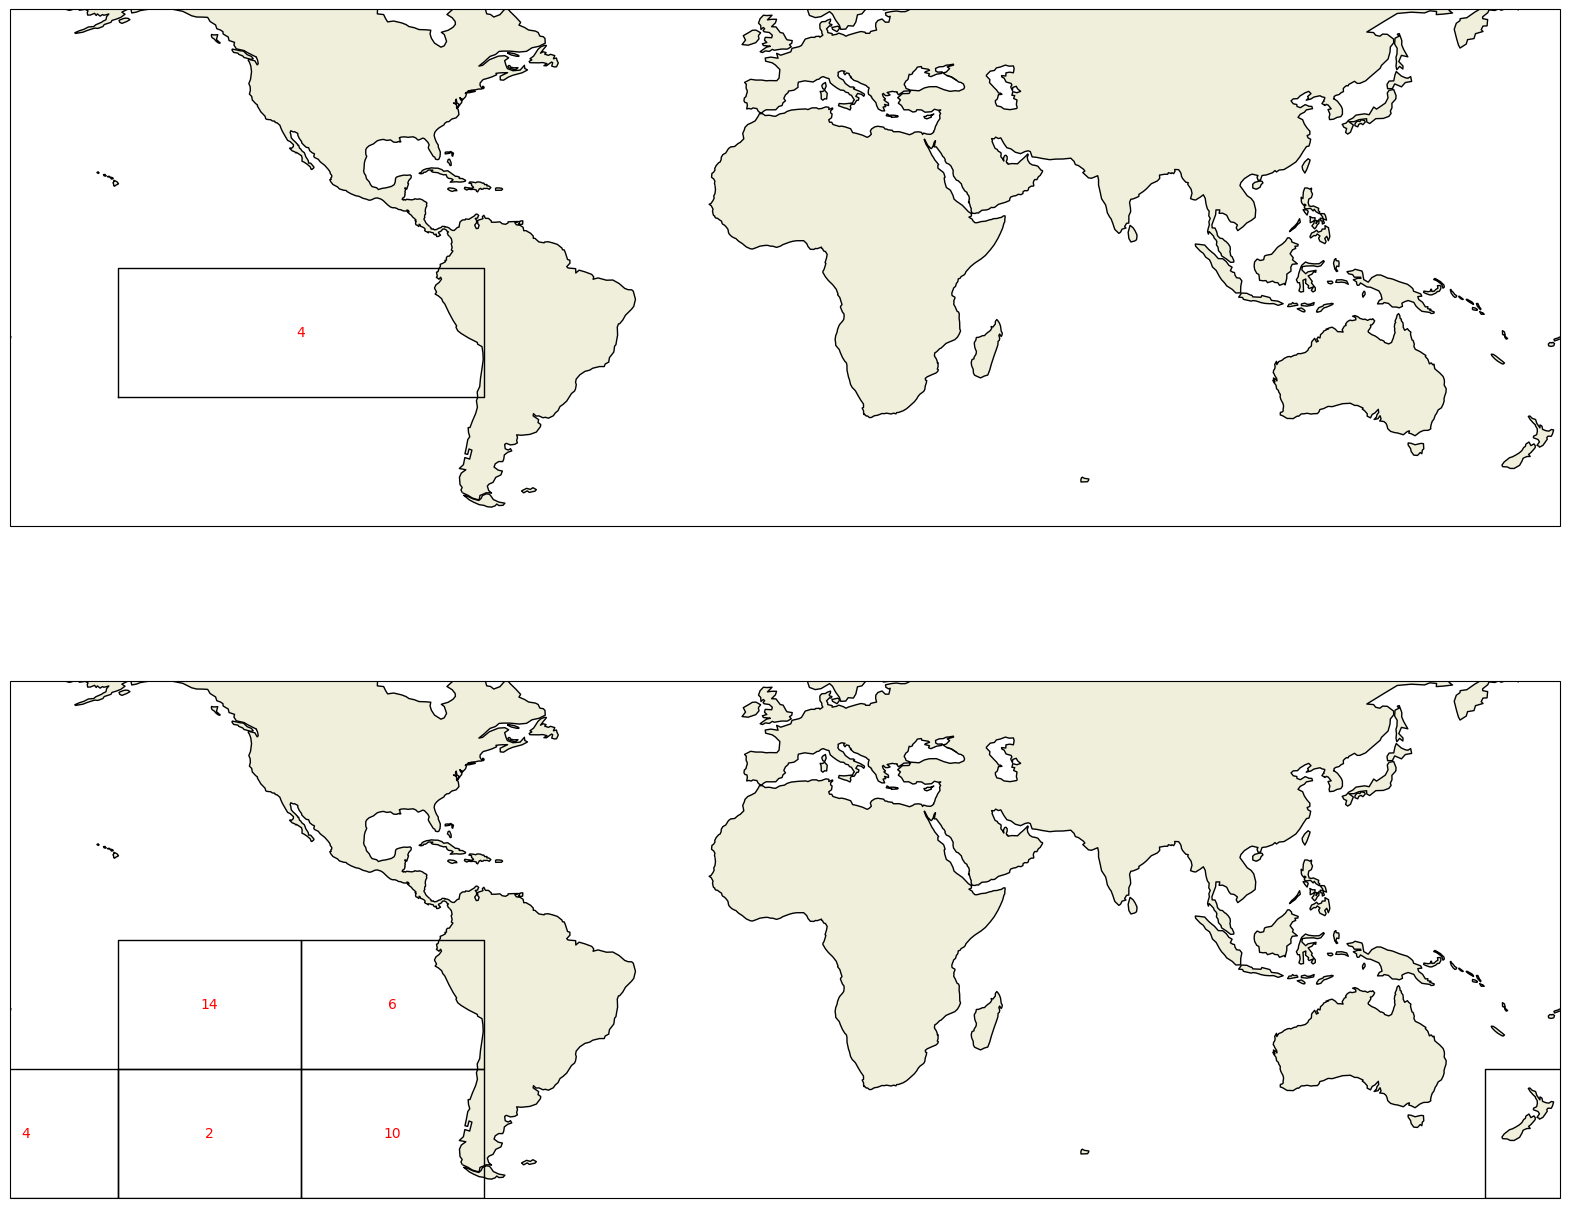

In [70]:
plot_grid_count(df1)

In [71]:
with open("pcas_t2m.pkl", "rb") as inp:
    pcas_t2m = pickle.load(inp)
df2 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["only_sea"] == False:
        temp = "_t2m"
        data_file = pd.read_parquet(f"data/new_features{temp}/{region}/predictor_{id}_{season}.parquet")
        if "PDO" not in str(row["extra_indices"]):
            pcas = list(data_file.columns[5:])
        else:
            pcas = list(data_file.columns[5:-3])
            for index in list(data_file.columns[-3:]):
                df1.loc[k] = [id, None, None, None, index]
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_t2m[id_pca].variables_dict.values())
            box = pcas_t2m[id_pca].box
            mode = pcas[i][-1]
            df2.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_t2m
display(df2)

,id_data,id_pca,mode,box,variables
0,9274c47c,1360,1,"[205, 290, -30, 0]","[U10, V10, Z]"
1,9274c47c,1338,1,"[205, 290, -30, 0]","[U10, V10]"
2,9274c47c,1339,2,"[205, 290, -30, 0]","[U10, Z]"
3,9274c47c,848,3,"[162.5, 205, -60, -30]","[SP, V10, T2M]"
4,9274c47c,730,1,"[247.5, 290, -30, 0]","[U10, V10, Z]"
...,...,...,...,...,...
95,297f6641,859,2,"[162.5, 205, -60, -30]","[V10, Z, T2M]"
96,297f6641,740,1,"[247.5, 290, -30, 0]","[SP, U10, V10, Z]"
97,297f6641,1110,3,"[205, 290, 30, 60]","[U10, Z, T2M]"
98,297f6641,1278,3,"[120, 205, -30, 0]","[V10, Z]"


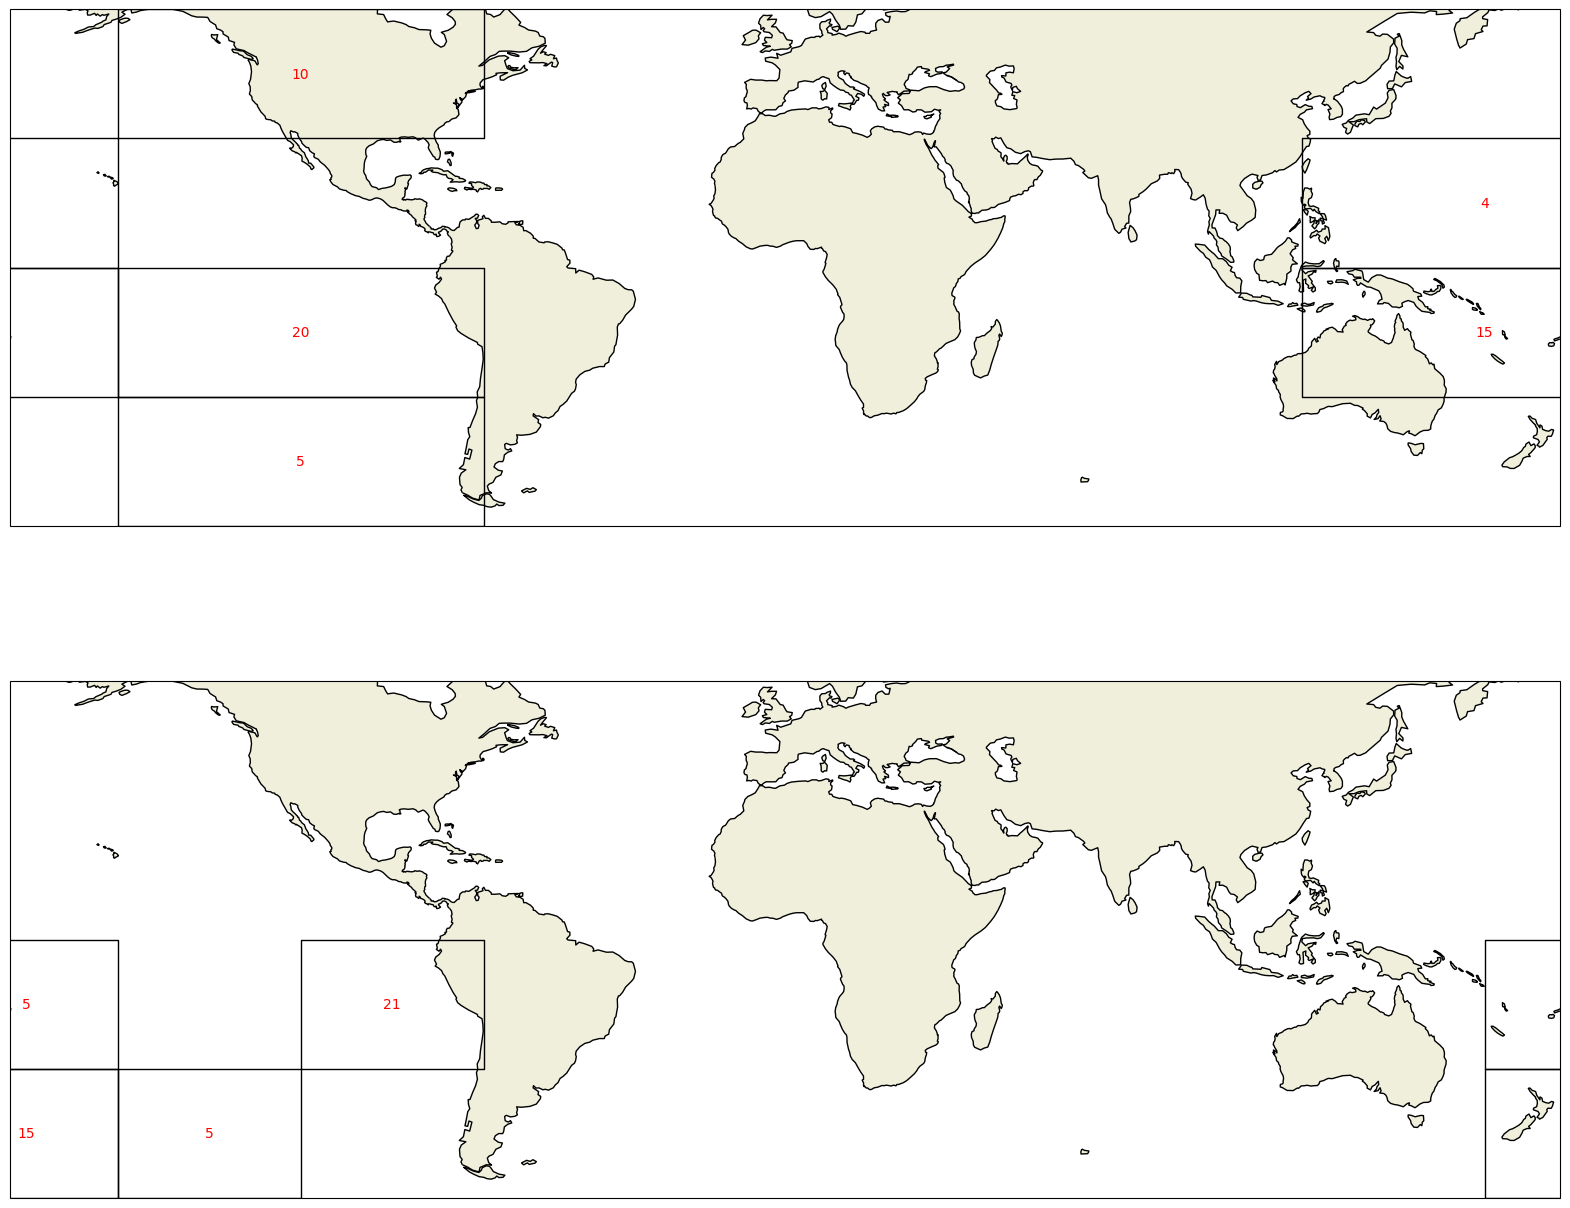

In [72]:
plot_grid_count(df2)

### OLD RESULTS

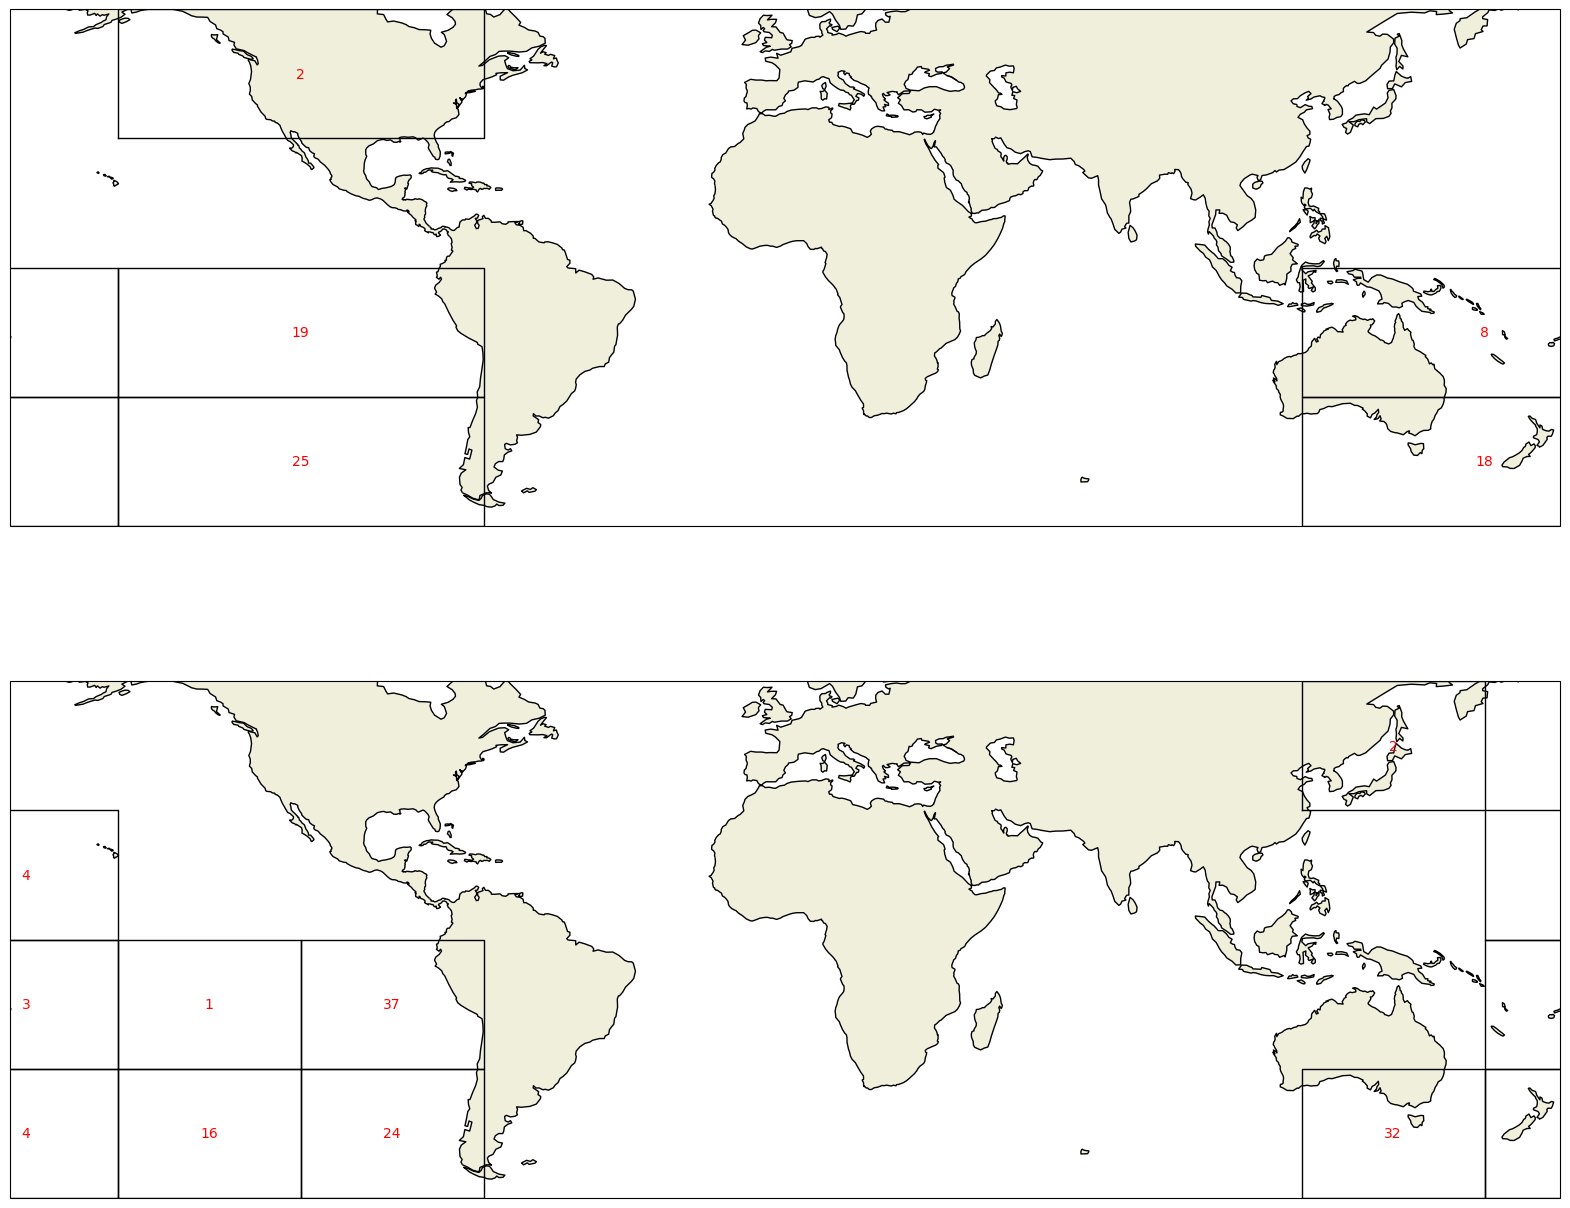

In [33]:
plot_grid_count(df1)

In [34]:
with open("pcas_t2m.pkl", "rb") as inp:
    pcas_t2m = pickle.load(inp)
df2 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["var_temp"] == "t2m":
        temp = "_t2m"
        with open("pcas_t2m.pkl", "rb") as inp:
            pcas_t2m = pickle.load(inp)
        data_file = pd.read_parquet(f"data/new_features{temp}/{region}/predictor_{id}_{season}.parquet")
        pcas = list(data_file.columns[5:])
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_t2m[id_pca].variables_dict.values())
            box = pcas_t2m[id_pca].box
            mode = pcas[i][-1]
            df2.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_t2m
display(df2)

,id_data,id_pca,mode,box,variables
0,76c7ef4c,965,2,"[247.5, 290, -60, -30]","[Z, T2M]"
1,76c7ef4c,885,1,"[205, 247.5, -60, -30]",[V10]
2,76c7ef4c,766,1,"[120, 162.5, -60, -30]","[SP, T2M]"
3,76c7ef4c,780,2,"[120, 162.5, -60, -30]","[SP, TTR, T2M]"
4,76c7ef4c,887,2,"[205, 247.5, -60, -30]",[T2M]
5,6b480627,965,2,"[247.5, 290, -60, -30]","[Z, T2M]"
6,6b480627,885,1,"[205, 247.5, -60, -30]",[V10]
7,6b480627,766,1,"[120, 162.5, -60, -30]","[SP, T2M]"
8,6b480627,780,2,"[120, 162.5, -60, -30]","[SP, TTR, T2M]"
9,6b480627,887,2,"[205, 247.5, -60, -30]",[T2M]


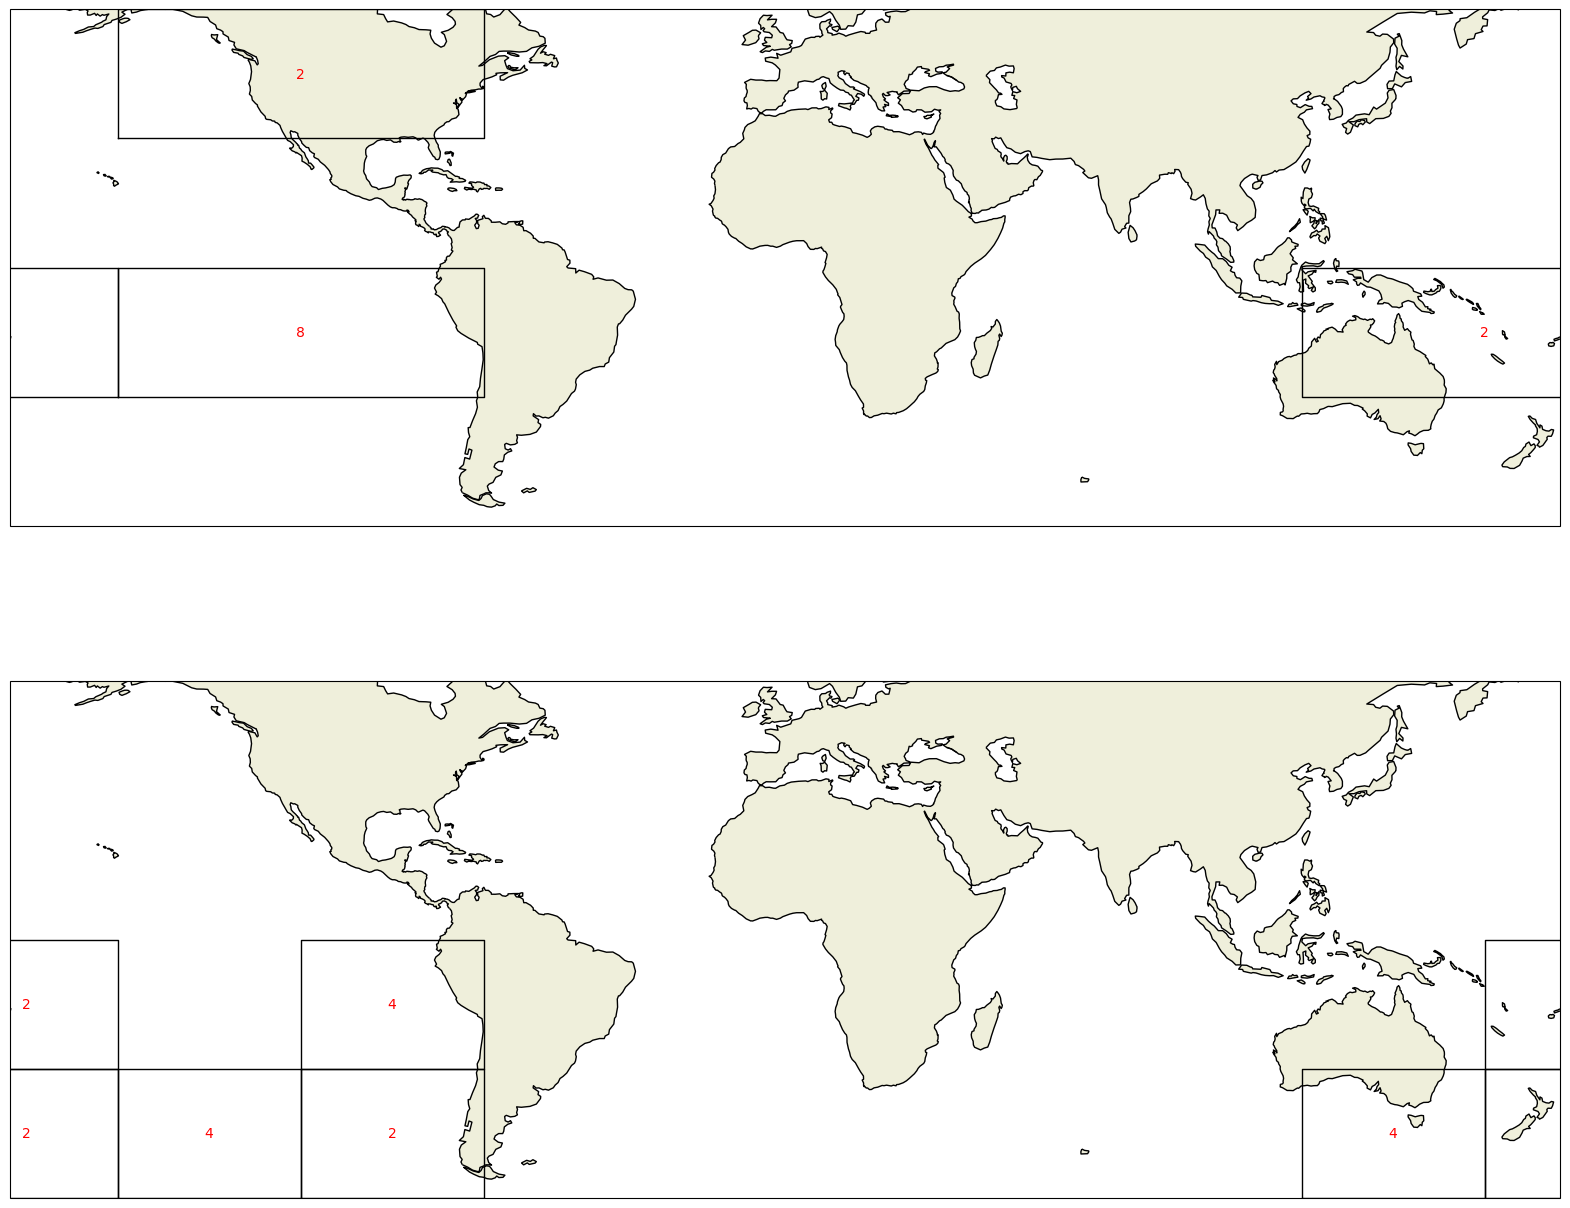

In [35]:
plot_grid_count(df2)